# Running pfNMF on Marjanovic sample Kras30 using Kras 12
To estimates the aplicability of GEPs from the Kras sample at 12 weeks (K12) on the cells from Kras 30 weeks (K30), we use the K12 GEPs readjusted to the jointly highly variable genes (jHVGs) to decompose the K30 dataset using the partially fixed NMF algorithm (pfnmf)

steps:
1.  Loading the data
2.  Finding jointly highly variable genes
3.  Ruuning NNLS to get the K12 GEPs on the jHVGs
4.  Decomposing the K30 dataset de-novo at K12 rank with 0, 1, 2, 3 additional programs
5.  Decomposing the K30 dataset using pfnmf with 0, 1, 2, 3 additional novel programs
6.  Evaluating the usage patterns of the different decompositions
7.  Evaluating the gene coefficients of the different GEPs from the different decompositions
8.  Graphing the gene coefficinets correlations between the GEPs of the different decompositions.

## Imports and loading data

In [6]:
%%time
%load_ext autoreload
%autoreload 2

import sys
import os

from urllib.request import urlretrieve
from argparse import Namespace

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.decomposition import _nmf as sknmf
from scipy.stats import rankdata
from scipy.cluster import hierarchy

from gepdynamics import _utils
from gepdynamics import _constants
from gepdynamics import cnmf
from gepdynamics import pfnmf

# Move to the project's home directory, as defined in _constants
_utils.cd_proj_home()
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/cs/labs/mornitzan/yotamcon/gep-dynamics
CPU times: user 1.06 ms, sys: 2.54 ms, total: 3.6 ms
Wall time: 28.9 ms


In [7]:
%%time
import torch
assert torch.cuda.is_available()
device = 'cuda'

CPU times: user 22 µs, sys: 6 µs, total: 28 µs
Wall time: 32.9 µs


/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


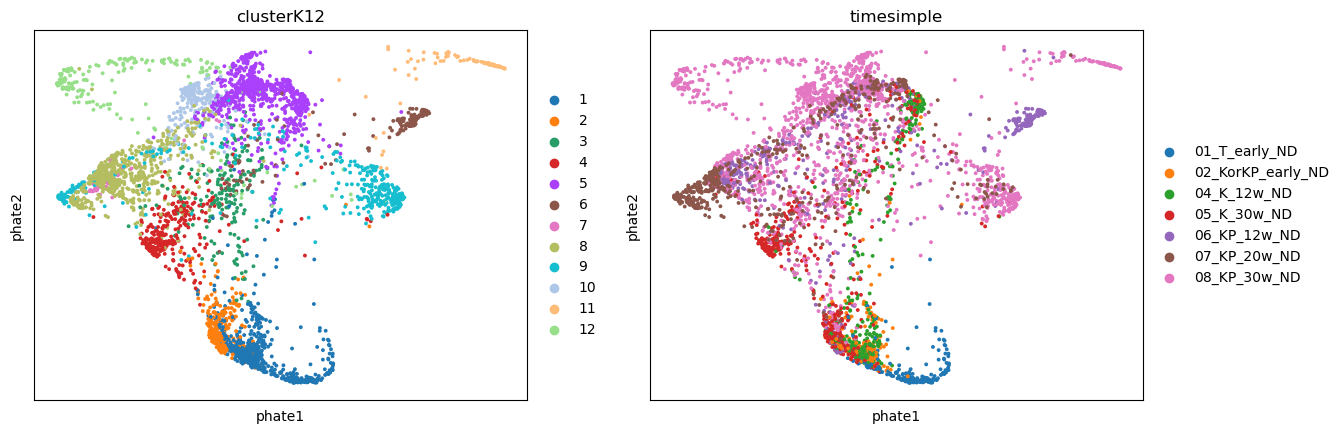

AnnData object with n_obs × n_vars = 3891 × 30999
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12', 'n_counts', 'n_genes'
    var: 'ensgID', 'geneSymbol', 'length', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'timesimple_colors', 'clusterK12_colors'
    obsm: 'X_phate', 'X_tsne'

In [8]:
results_dir = _utils.set_dir('results')
notebook_dir = _utils.set_dir(results_dir.joinpath('marjanovic_k12_k30_pfnmf'))
orig_adata_path = results_dir.joinpath('marjanovic_mmLungPlate.h5ad')
split_adatas_dir = _utils.set_dir(results_dir.joinpath('marjanovic_mmLungPlate_split'))

adata = sc.read(orig_adata_path)
sc.external.pl.phate(adata, color=['clusterK12', 'timesimple'])
adata

In [9]:
k_12 = sc.read_h5ad(split_adatas_dir.joinpath('04_K_12w_ND_GEPs.h5ad'))
k_12

AnnData object with n_obs × n_vars = 455 × 30999
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12', 'n_counts', 'n_genes'
    var: 'ensgID', 'geneSymbol', 'length', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusterK12_colors', 'cnmf_params', 'hvg', 'name', 'sname', 'timesimple_colors'
    obsm: 'X_phate', 'X_tsne', 'row_colors', 'usages', 'usages_norm'
    varm: 'usage_coefs'

In [10]:
k_30 = sc.read_h5ad(split_adatas_dir.joinpath('05_K_30w_ND_GEPs.h5ad'))
k_30

AnnData object with n_obs × n_vars = 505 × 30999
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12', 'n_counts', 'n_genes'
    var: 'ensgID', 'geneSymbol', 'length', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusterK12_colors', 'cnmf_params', 'hvg', 'name', 'sname', 'timesimple_colors'
    obsm: 'X_phate', 'X_tsne', 'row_colors', 'usages', 'usages_norm'
    varm: 'usage_coefs'

## Running pfNMF on K30 using the K12 GEPs

### Preparing K12 and K30 data on joint highly variable genes (jHVGs)


In [11]:
var_subset = (k_12.var.n_cells >= 5) & (k_30.var.n_cells >= 5)
obs_subset = adata.obs.timesimple.isin([k_12.uns['name'], k_30.uns['name']])

joint_K12_K30_var = sc.pp.highly_variable_genes(
    adata[obs_subset, var_subset], flavor='seurat_v3',
    n_top_genes=_constants.NUMBER_HVG, inplace=False)
joint_K12_K30_var

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


means     variances  \
geneID                                                       
ENSMUSG00000000001.4_Gnai3        194.888542  5.199244e+04   
ENSMUSG00000000028.14_Cdc45         5.904417  1.503283e+03   
ENSMUSG00000000056.7_Narf          27.791667  4.079177e+03   
ENSMUSG00000000058.6_Cav2          95.040625  2.757632e+04   
ENSMUSG00000000078.7_Klf6         206.710417  2.356955e+05   
...                                      ...           ...   
ENSMUSG00000114942.1_Lats2          2.674948  2.773830e+02   
ENSMUSG00000114951.1_AC238811.4     0.074979  2.453808e-01   
ENSMUSG00000114960.1_AC115289.2     0.161219  1.055823e+01   
kallistoKRASG12D_KRASG12D           4.680199  2.176566e+02   
tdTomato_tdTomato                3311.544792  6.697476e+06   

                                 highly_variable_rank  variances_norm  \
geneID                                                                  
ENSMUSG00000000001.4_Gnai3                        NaN        0.979725   
ENSMUSG00000000028.14_Cdc45                    1388.0        2.168086   
ENSMUSG00000000056.7_Narf                         NaN        0.933303   
ENSMUSG00000000058.6_Cav2                         NaN        1.421634   
ENSMUSG00000000078.7_Klf6                       106.0        3.823077   
...                                               ...             ...   
ENSMUSG00000114942.1_Lats2                        NaN        1.155601   
ENSMUSG00000114951.1_AC238811.4                   NaN        0.671681   
ENSMUSG00000114960.1_AC115289.2                1951.0        2.026982   
kallistoKRASG12D_KRASG12D                         NaN        0.426045   
tdTomato_tdTomato                                 NaN        0.964629   

                                 highly_variable  
geneID                                            
ENSMUSG00000000001.4_Gnai3                 False  
ENSMUSG00000000028.14_Cdc45                 True  
ENSMUSG00000000056.7_Narf                  False  
ENSMUSG00000000058.6_Cav2                  False  
ENSMUSG00000000078.7_Klf6                   True  
...                                          ...  
ENSMUSG00000114942.1_Lats2                 False  
ENSMUSG00000114951.1_AC238811.4            False  
ENSMUSG00000114960.1_AC115289.2             True  
kallistoKRASG12D_KRASG12D                  False  
tdTomato_tdTomato                          False  

[20589 rows x 5 columns]

In [12]:
print("Selecting 2000 joint HVGs, intersection with K12 HVGS is "
      f"{np.sum(joint_K12_K30_var.highly_variable & k_12.var.highly_variable)}"
      ", and with K30 is "
      f"{np.sum(joint_K12_K30_var.highly_variable & k_30.var.highly_variable)}")
joint_K12_K30_HVG = joint_K12_K30_var[joint_K12_K30_var.highly_variable].index

Selecting 2000 joint HVGs, intersection with K12 HVGS is 881, and with K30 is 811


In [13]:
# Variance normalized version of K12 data on the jHVGs
X12 = sc.pp.scale(k_12[:, joint_K12_K30_HVG].X.toarray(), zero_center=False)
print(f'X12.shape = {X12.shape}')
X12[:4, :4]

X12.shape = (455, 2000)


array([[0.        , 0.01119922, 0.        , 0.        ],
       [0.        , 0.24478301, 0.        , 0.        ],
       [0.        , 0.9135366 , 0.        , 0.00701734],
       [0.        , 0.        , 0.        , 0.        ]], dtype=float32)

In [14]:
# Variance normalized version of K30 data on the jHVGs
X30 = sc.pp.scale(k_30[:, joint_K12_K30_HVG].X.toarray(), zero_center=False)
print(f'X30.shape = {X30.shape}')
X30[:4, :4]

X30.shape = (505, 2000)


array([[1.8623625 , 0.06579945, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.33265278, 0.        , 0.        ]], dtype=float32)

### Running NNLS to get K12 GEPs (geps12) on jHVGs

In [15]:
#Parameters
beta_loss = 'kullback-leibler'
max_iter = 800

# Usage proportions of the k_12 programs on k_12 data
100 * k_12.obsm['usages_norm'].sum(axis=0) / k_12.n_obs

array([26.991241 , 43.953407 , 12.164866 ,  6.721589 ,  2.9566545,
        7.2122273], dtype=float32)

In [16]:
# Working in the transposed notation to get the programs: X.T ~ H.T @ W.T

nmf_kwargs={'H': k_12.obsm['usages'].T.copy(),
            'update_H': False,
            'tol': _constants.NMF_TOLERANCE,
            'max_iter': max_iter,
            'beta_loss': beta_loss
           }

tens = torch.tensor(X12.T).to(device)

W, H, n_iter = cnmf.nmf_torch(X12.T, nmf_kwargs, tens, verbose=True)
print(f'Error per sample = {(sknmf._beta_divergence(X12.T, W, H, beta_loss) / k_12.n_obs): .1f}')

del tens

geps12 = W.T
geps12.shape

beta 1 loss = 304212.5625, # iterations was 40
Error per sample =  668.6


(6, 2000)

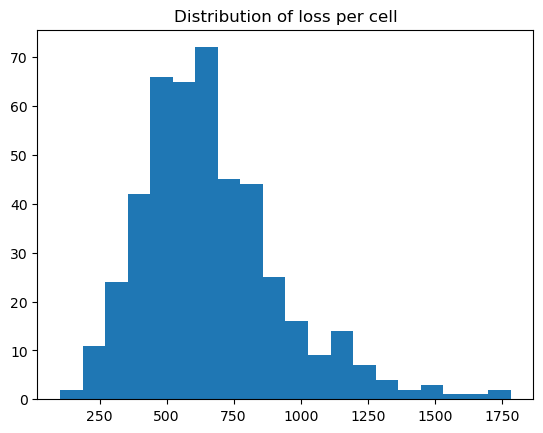

In [17]:
loss_per_cell = pfnmf.calc_beta_divergence(X12.T, W, np.zeros((2000, 0)), H, np.zeros((0, 455)), per_column=True)

plt.hist(loss_per_cell, bins=20)
plt.title('Distribution of loss per cell')
plt.show()

In [18]:
np.percentile(loss_per_cell, 90)

1007.3061599263732

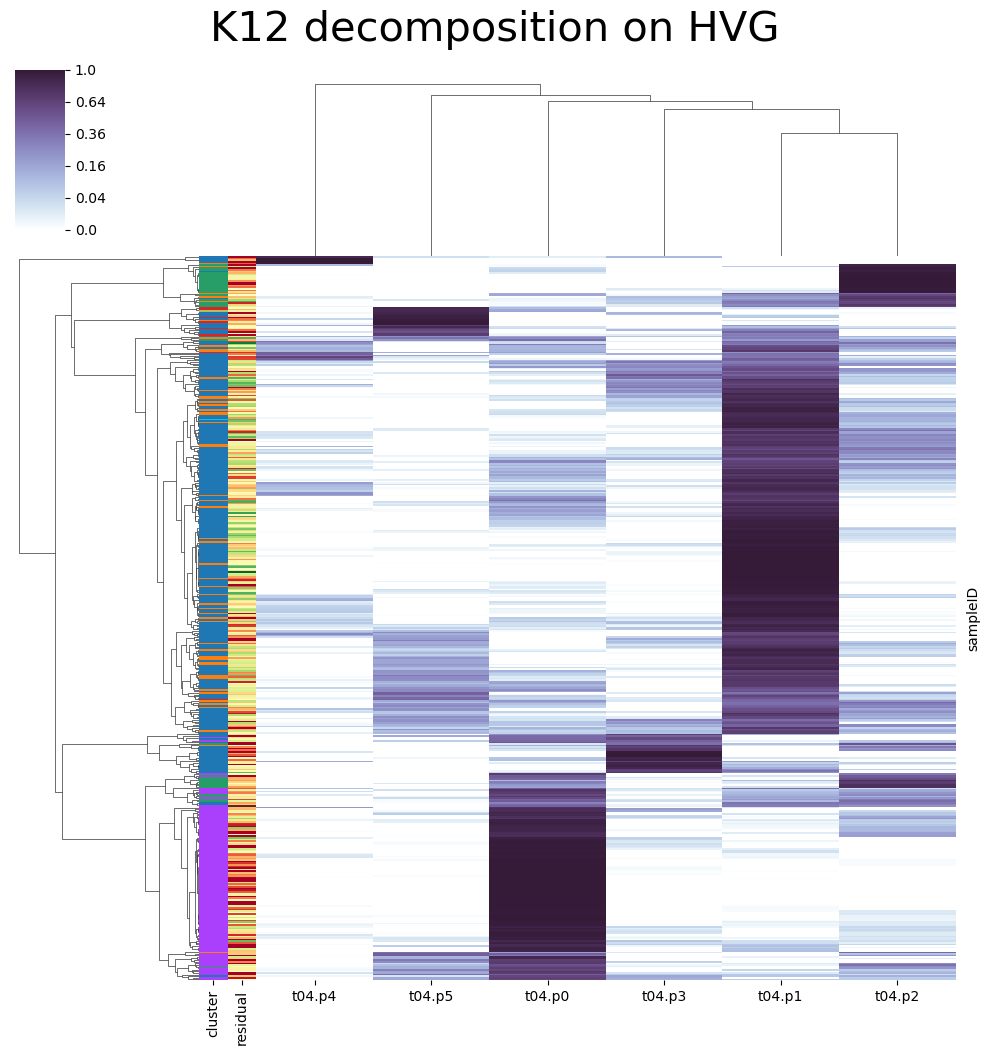

In [19]:
row_colors = pd.concat([pd.Series(k_12.obsm.get('row_colors'), name='cluster', index=k_12.obs.index),
                       pd.Series(_utils.floats_to_colors(loss_per_cell, cmap='RdYlGn_r', vmax=1000), name='residual', index=k_12.obs.index)], axis=1)

un_sns = _utils.plot_usages_norm_clustermaps(k_12, normalized_usages=(H / np.sum(H, axis=0, keepdims=True)).T,
    title='K12 decomposition on HVG', show=True, sns_clustermap_params={'row_colors': row_colors})

### Decomposing the K30 dataset de-novo (on jHVGs) at K12 rank with 0, 1, 2, 3 additional programs

In [20]:
decompositions = {}   # {name: namespace}
# pfnmf_results = {}
# denovo_results = {}
rank_k12 = geps12.shape[0]
max_added_rank = 4

In [21]:
%%script --no-raise-error false

tens = torch.tensor(X30).to(device)

for added_rank in range(max_added_rank + 1):
    rank = rank_k12 + added_rank
    
    nmf_kwargs={
        'n_components': rank,
        'tol': _constants.NMF_TOLERANCE,
        'max_iter': max_iter,
        'beta_loss': beta_loss
       }

    W, H, n_iter = cnmf.nmf_torch(X30, nmf_kwargs, tens, verbose=False)

    loss = sknmf._beta_divergence(X30, W, H, beta_loss) / k_30.n_obs
    
    sname = f'dn_{rank}'
    ns = Namespace(
        name=sname,
        algorithm='regular',
        W=W,
        H=H,
        rank=rank,
        n_iter=n_iter,
        loss=loss)
    
    decompositions[sname] = ns
    
    print(f'Error per sample for rank {ns.rank} ({ns.n_iter} iterations) = {ns.loss: .1f}')

del tens

Error per sample for rank 6 (620 iterations) =  649.6
Error per sample for rank 7 (640 iterations) =  632.7
Error per sample for rank 8 (390 iterations) =  622.9
Error per sample for rank 9 (560 iterations) =  609.0
Error per sample for rank 10 (800 iterations) =  596.5


### Decomposing K30 with geps12 and no additional programs

In [22]:
%%script --no-raise-error false

#  x30 ~ W @ geps12

nmf_kwargs={'H': geps12.copy(),
            'update_H': False,
            'tol': _constants.NMF_TOLERANCE,
            'max_iter': max_iter,
            'beta_loss': beta_loss
           }

tens = torch.tensor(X30).to(device)

W, H, n_iter = cnmf.nmf_torch(X30, nmf_kwargs, tens, verbose=False)

del tens

loss = sknmf._beta_divergence(X30, W, H, beta_loss) / k_30.n_obs


sname = f'k12'
ns = Namespace(
    name=sname,
    algorithm='regular',
    W=W,
    H=H,
    rank=rank_k12,
    n_iter=n_iter,
    loss=loss)

decompositions[sname] = ns

print(f'Error per sample ({ns.n_iter} iterations) = {(ns.loss): .1f}')


Error per sample (50 iterations) =  762.0


### Decomposing K30 with geps12 and additional programs

In [24]:
%%script --no-raise-error false

# pfnmf is written for constant W_1, so we will transpose as needed:
# x30 ~ W_1 @ geps12 + W_2 @ H_2  <--> x30.T ~ geps12.T @ W_1.T + H_2.T @ W_2.T

for added_rank in range(1, max_added_rank + 1):
    print(f"Working on added rank = {added_rank}")
    
    sname = f'k12e{added_rank}'
    rank = rank_k12 + added_rank
    
    best_loss = np.infty
    
    for repeat in range(20): 
        w1, h1, w2, h2, n_iter = pfnmf.pfnmf(X30.T, geps12.T, rank_2=added_rank, beta_loss=beta_loss,
            tol=_constants.NMF_TOLERANCE, max_iter=max_iter, verbose=False)

        final_loss = pfnmf.calc_beta_divergence(X30.T, w1, w2, h1, h2, beta_loss)
        
        if final_loss <= best_loss:
            best_loss = final_loss
            
            ns = Namespace(
                name=sname,
                algorithm='pfnmf',
                w1=w1,
                h1=h1,
                w2=w2,
                h2=h2,
                rank=rank,
                n_iter=n_iter,
                loss=best_loss / k_30.n_obs)

            decompositions[sname] = ns

            print(f"repeat {repeat}, after {ns.n_iter} iterations reached error per sample = {ns.loss: .1f}")

Working on added rank = 1
repeat 0, after 132 iterations reached error per sample =  728.9
repeat 5, after 107 iterations reached error per sample =  728.9
repeat 6, after 122 iterations reached error per sample =  728.8
repeat 11, after 126 iterations reached error per sample =  728.7
Working on added rank = 2
repeat 0, after 215 iterations reached error per sample =  709.8
repeat 2, after 209 iterations reached error per sample =  707.6
repeat 6, after 168 iterations reached error per sample =  707.1
Working on added rank = 3
repeat 0, after 212 iterations reached error per sample =  695.1
repeat 1, after 190 iterations reached error per sample =  692.5
repeat 2, after 226 iterations reached error per sample =  692.3
repeat 3, after 293 iterations reached error per sample =  691.6
repeat 7, after 377 iterations reached error per sample =  687.3
repeat 15, after 322 iterations reached error per sample =  686.9
repeat 17, after 321 iterations reached error per sample =  686.5
Working o

In [26]:
%%script --no-raise-error false

np.savez_compressed(notebook_dir.joinpath('decompositions.npz'), decompositions=decompositions)

In [27]:
loaded = np.load(notebook_dir.joinpath('decompositions.npz'), allow_pickle=True)
print([key for key in loaded.keys()])

['decompositions']


In [28]:
decompositions = loaded['decompositions'].item()
for name, ns in decompositions.items():
    print(name, vars(ns).keys())

dn_6 dict_keys(['name', 'algorithm', 'W', 'H', 'rank', 'n_iter', 'loss'])
dn_7 dict_keys(['name', 'algorithm', 'W', 'H', 'rank', 'n_iter', 'loss'])
dn_8 dict_keys(['name', 'algorithm', 'W', 'H', 'rank', 'n_iter', 'loss'])
dn_9 dict_keys(['name', 'algorithm', 'W', 'H', 'rank', 'n_iter', 'loss'])
dn_10 dict_keys(['name', 'algorithm', 'W', 'H', 'rank', 'n_iter', 'loss'])
k12 dict_keys(['name', 'algorithm', 'W', 'H', 'rank', 'n_iter', 'loss'])
k12e1 dict_keys(['name', 'algorithm', 'w1', 'h1', 'w2', 'h2', 'rank', 'n_iter', 'loss'])
k12e2 dict_keys(['name', 'algorithm', 'w1', 'h1', 'w2', 'h2', 'rank', 'n_iter', 'loss'])
k12e3 dict_keys(['name', 'algorithm', 'w1', 'h1', 'w2', 'h2', 'rank', 'n_iter', 'loss'])
k12e4 dict_keys(['name', 'algorithm', 'w1', 'h1', 'w2', 'h2', 'rank', 'n_iter', 'loss'])


## Evaluating the added programs

### Preparing plotting parameters

In [29]:
columns_k12 = [f'k12.p{i}' for i in range(geps12.shape[0])]

coloring_scheme = {'k12': '#2ca02c', 'k12e1': 'limegreen', 'k12e2': 'yellow',
                   'k12e3': 'orange', 'k12e4': 'chocolate'}
coloring_scheme.update({f'dn_{rank_k12 + added_rank}': '#d62728' for added_rank in range(max_added_rank + 1)})

for sname, ns in decompositions.items():
    print(f"{sname}\t{ns.loss: .0f}")



dn_6	 650
dn_7	 633
dn_8	 623
dn_9	 609
dn_10	 597
k12	 762
k12e1	 729
k12e2	 707
k12e3	 686
k12e4	 669


In [30]:
# adding needed fields to the namespace objects

for sname, ns in decompositions.items():
    if ns.algorithm == 'pfnmf':
        ns.loss_per_cell = pfnmf.calc_beta_divergence(X30.T, ns.w1, ns.w2, ns.h1, ns.h2, per_column=True)
        usages = np.concatenate([ns.h1, ns.h2], axis=0).T
    else:
        ns.loss_per_cell = pfnmf.calc_beta_divergence(   # X30 ~ W @ H
            X30.T, ns.H.T, np.zeros((ns.H.shape[1], 0)), ns.W.T, np.zeros((0, ns.W.shape[0])), per_column=True)
        usages = ns.W
    
    ns.norm_usages = usages / np.linalg.norm(usages, 1, axis=1, keepdims=True)
    
    ns.prog_percentages = ns.norm_usages.sum(axis=0) * 100 / k_30.n_obs
    
    if ns.algorithm == 'pfnmf':
        ns.prog_names = [f'{sname}.p{i}' for i in range(rank_k12)]
        ns.prog_names.extend([f'{sname}.e{i}' for i in range(ns.rank - rank_k12)])
    else:
        ns.prog_names = [f'{sname}.p{i}' for i in range(ns.rank)]

    ns.prog_labels_1l = [name + f' ({ns.prog_percentages[i]: 0.1f}%)' for i, name in enumerate(ns.prog_names)]   
    ns.prog_labels_2l = [name + f'\n({ns.prog_percentages[i]: 0.1f}%)' for i, name in enumerate(ns.prog_names)]

### usages clustermaps

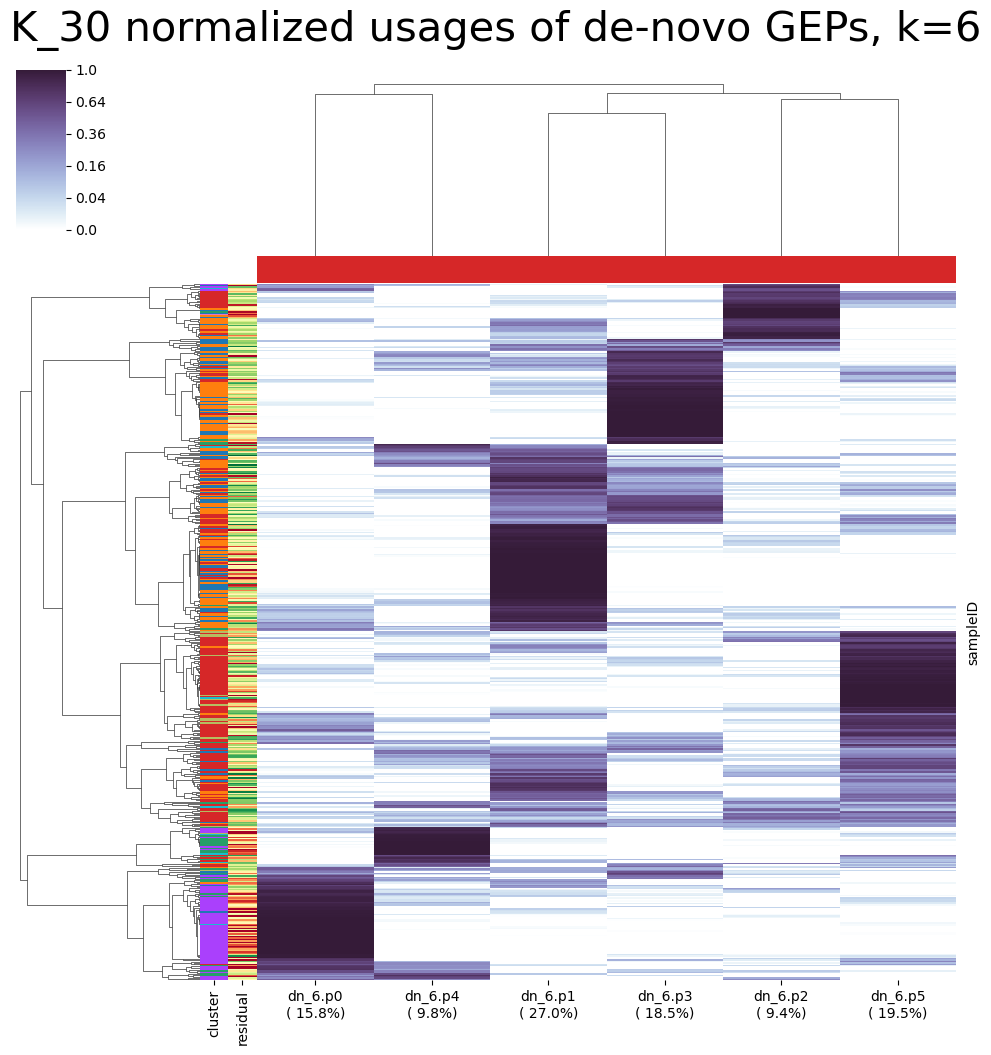

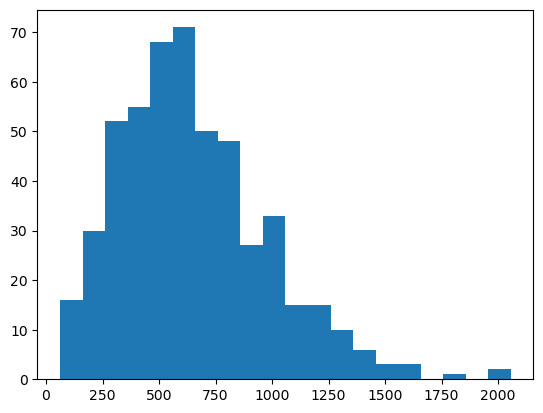

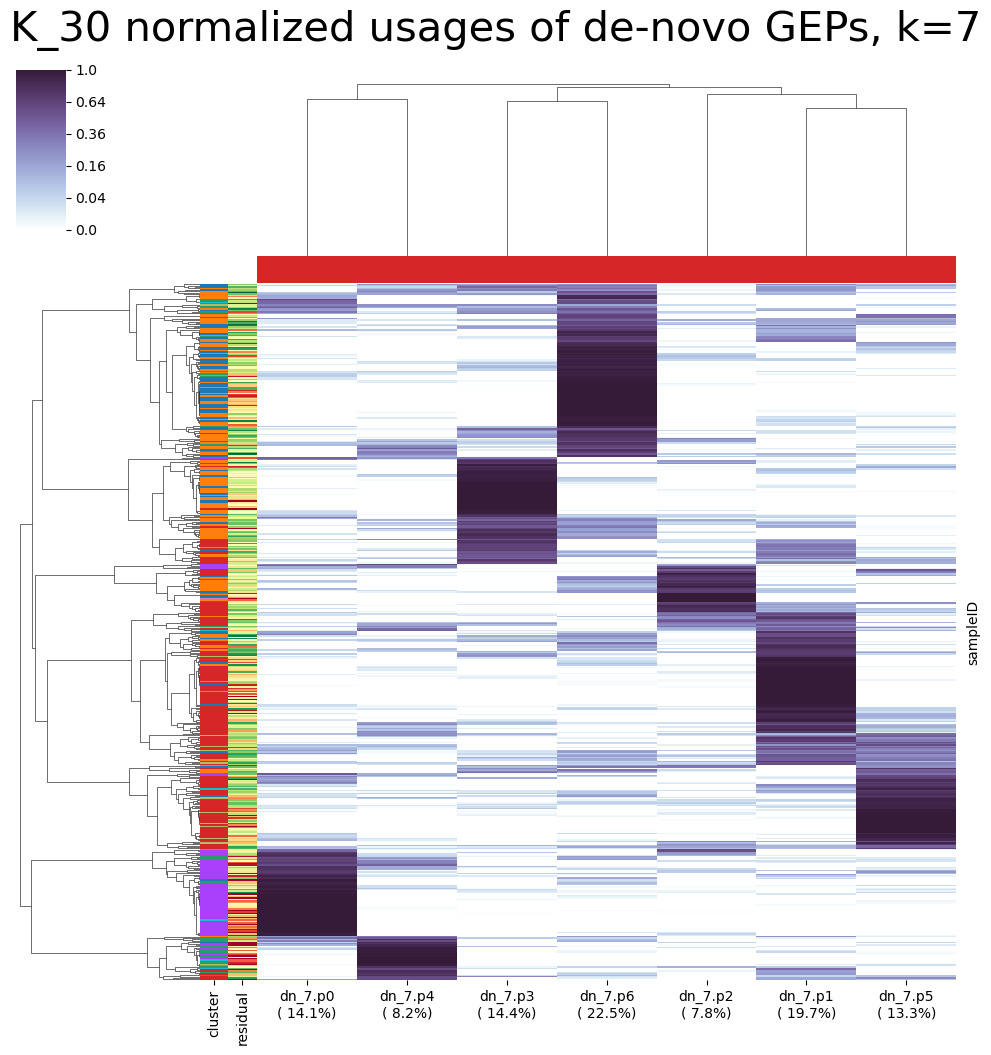

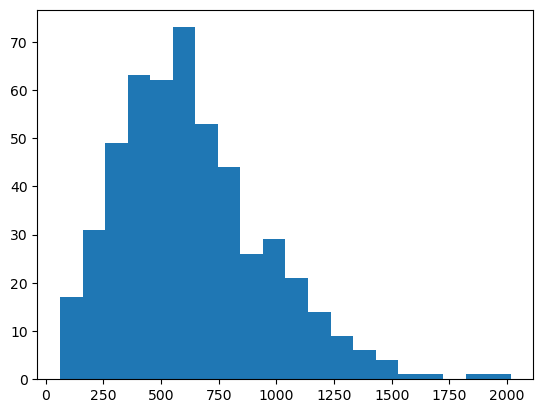

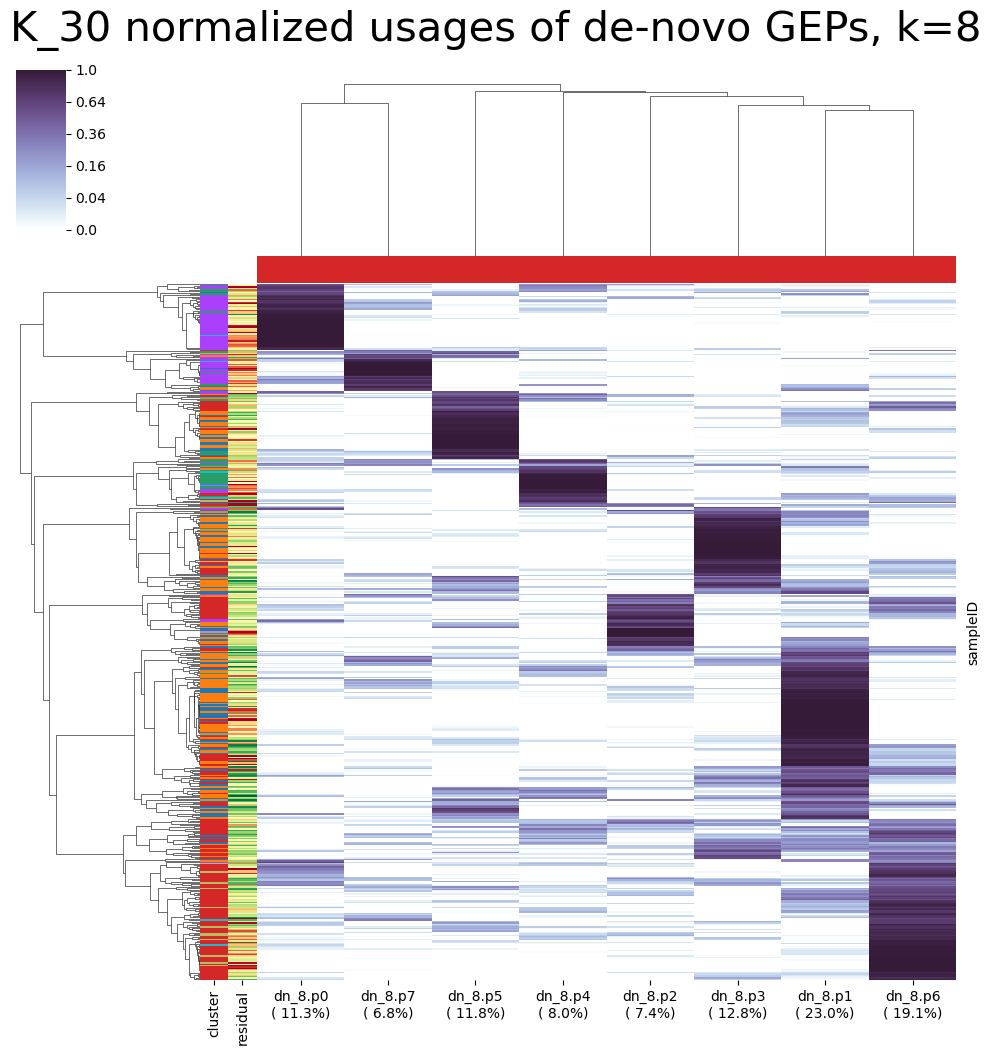

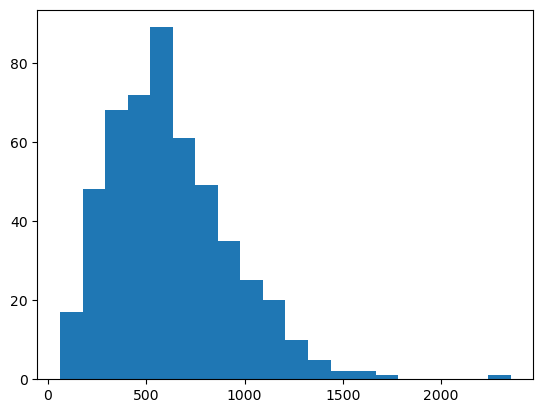

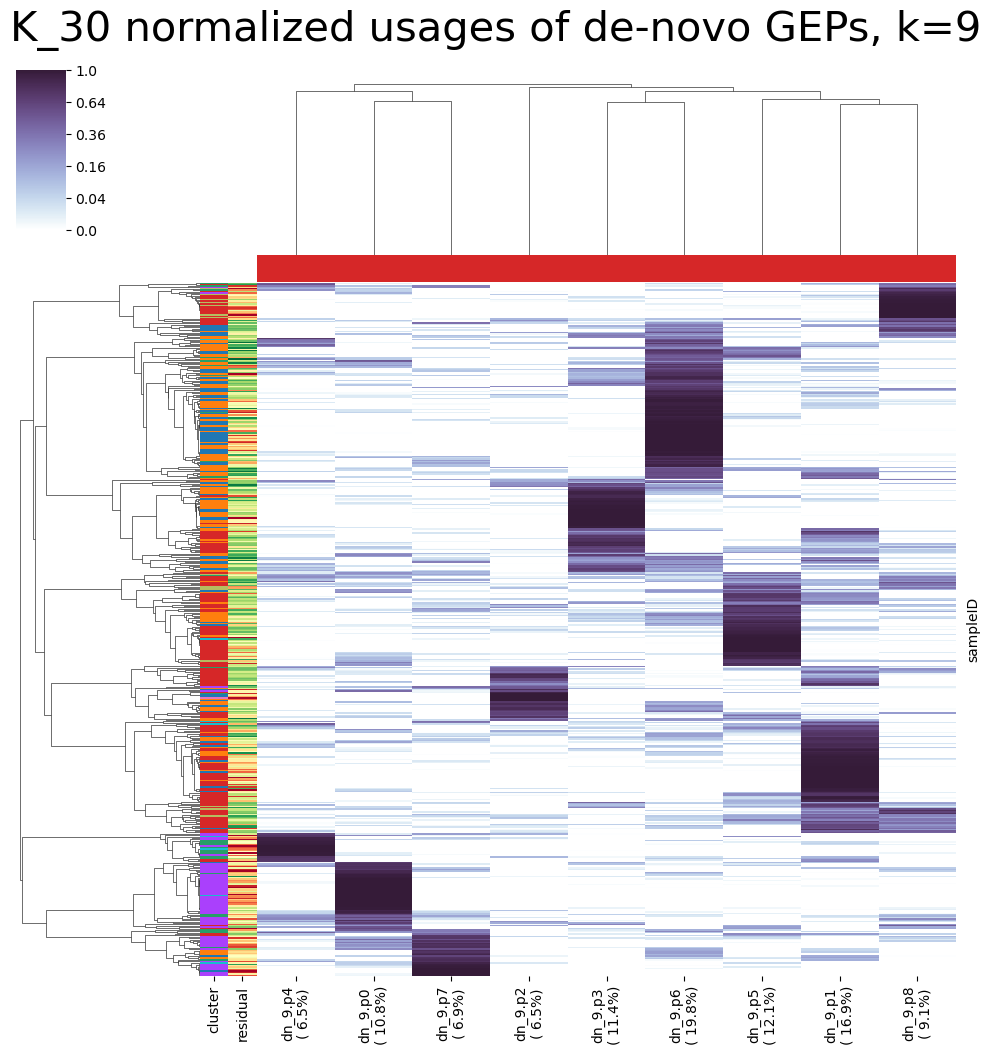

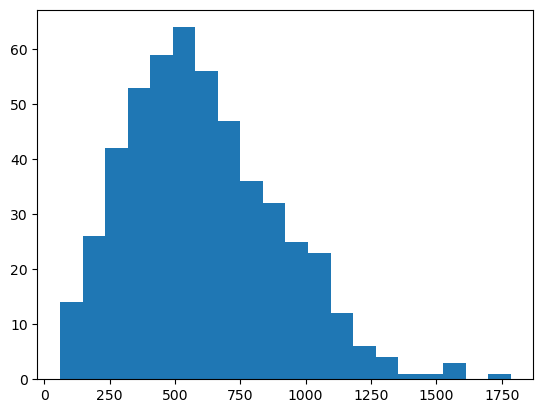

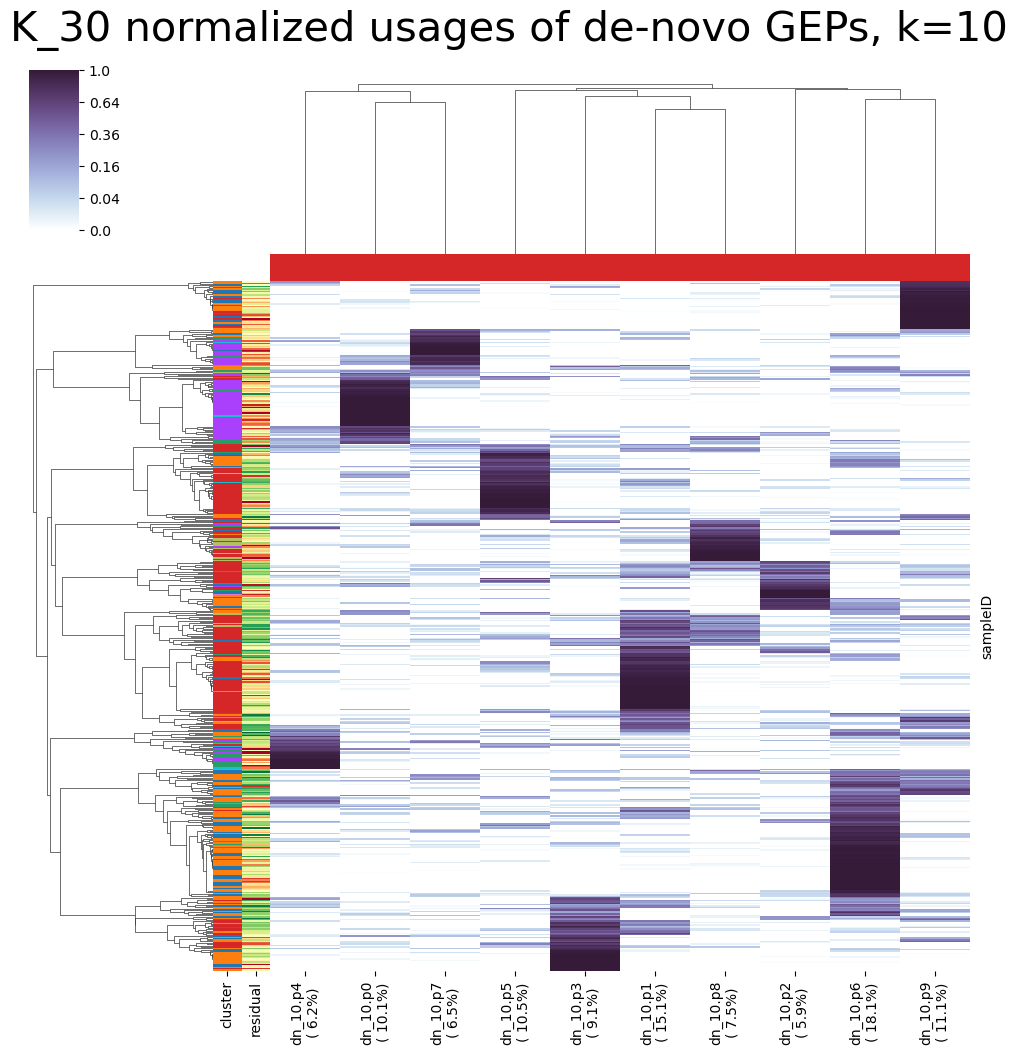

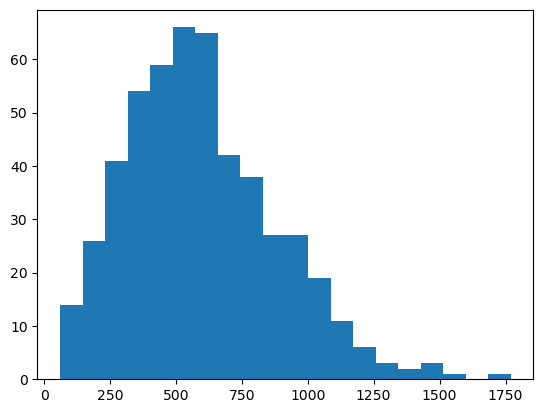

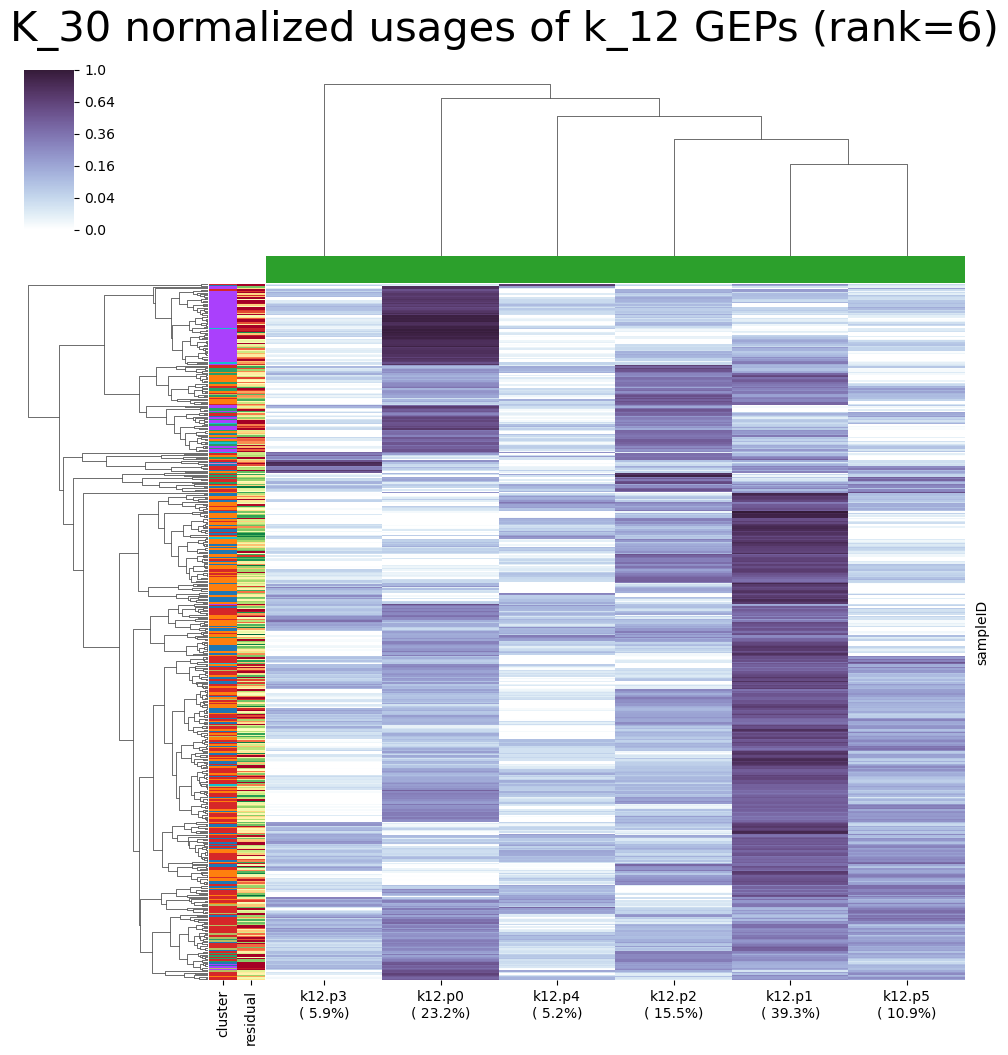

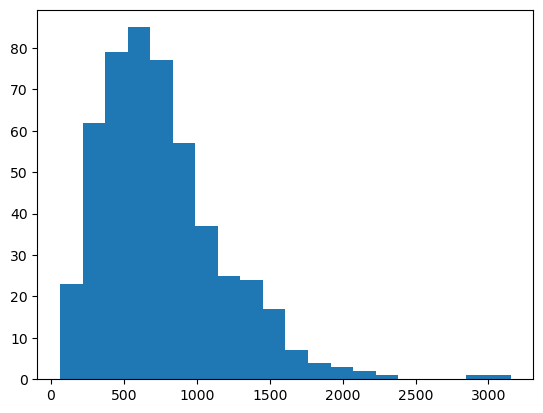

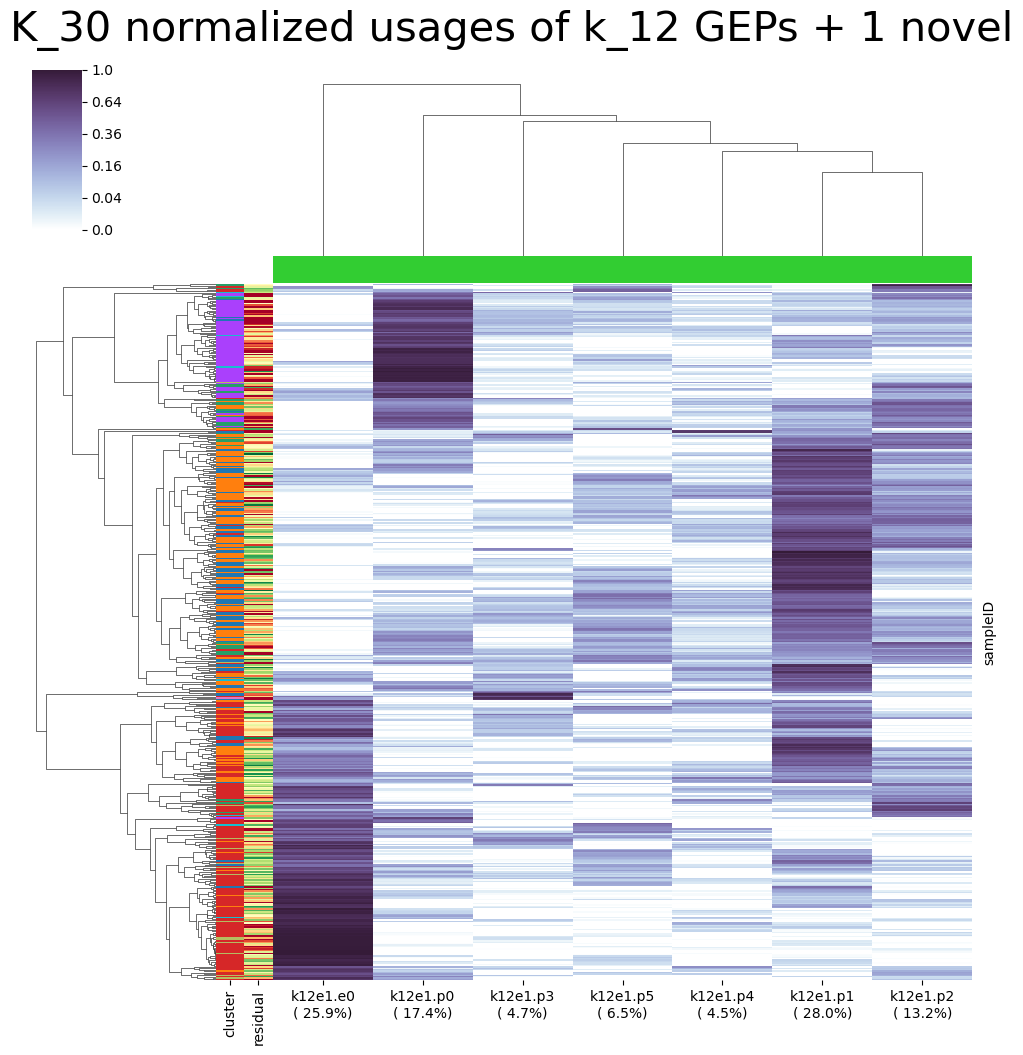

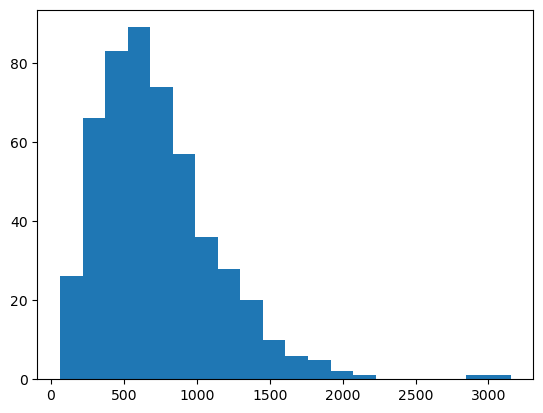

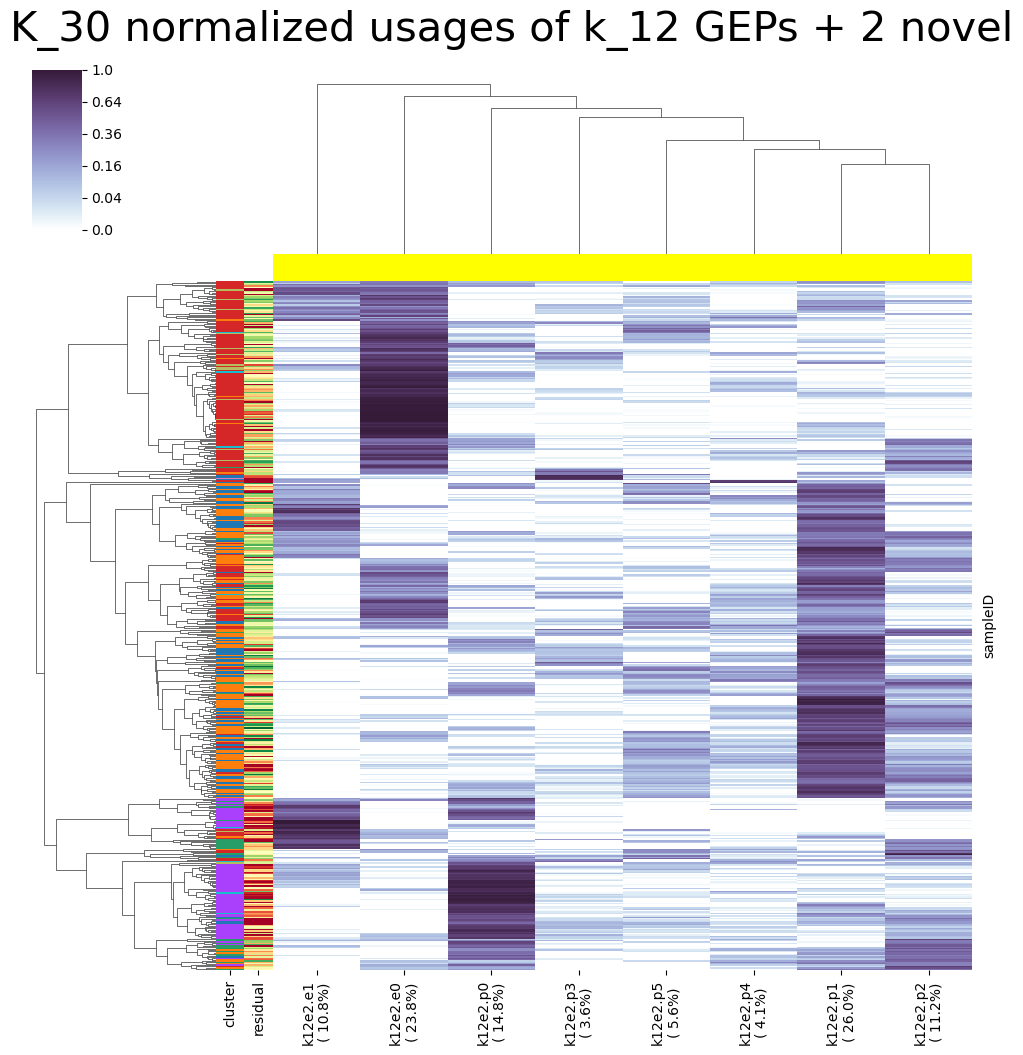

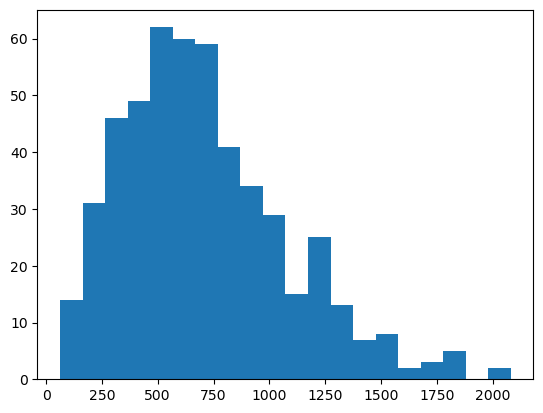

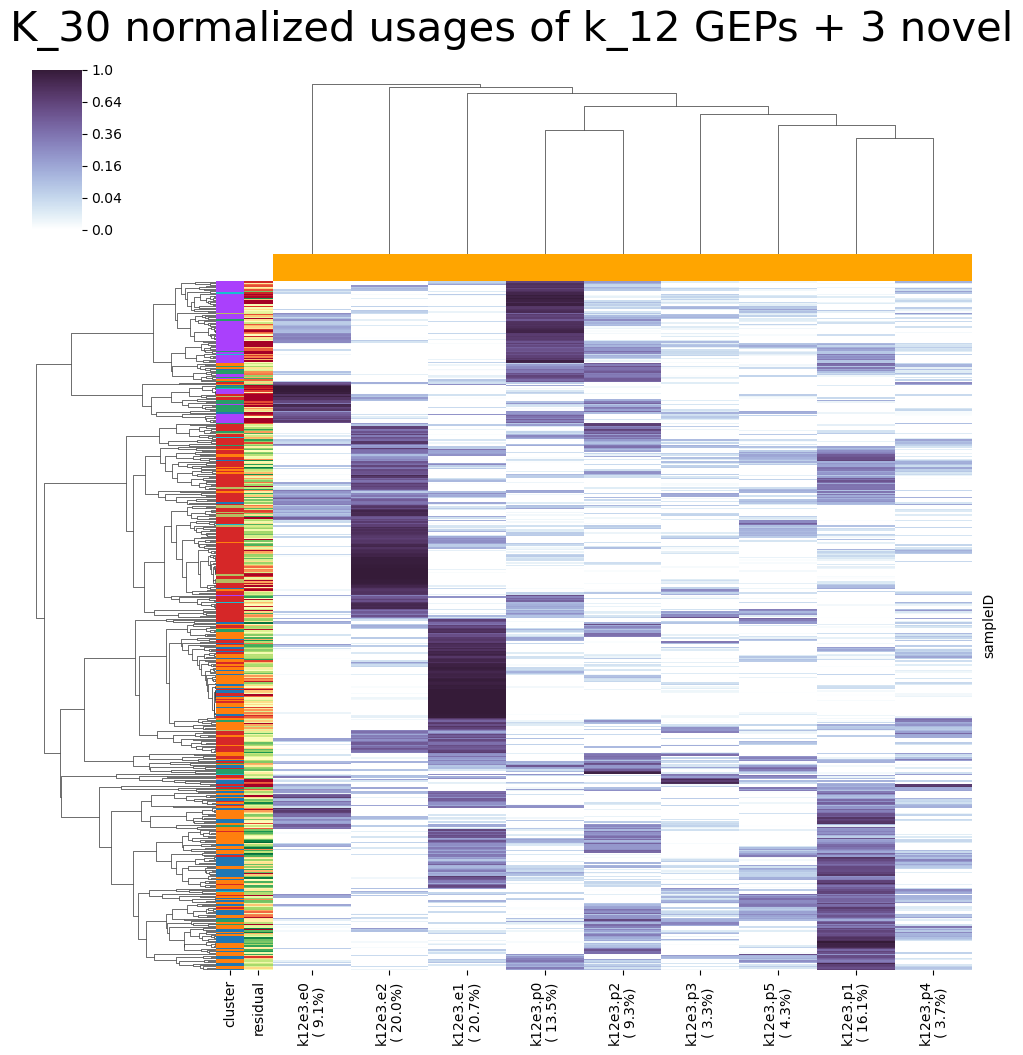

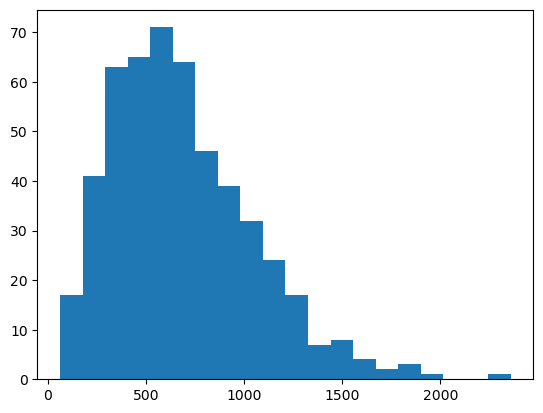

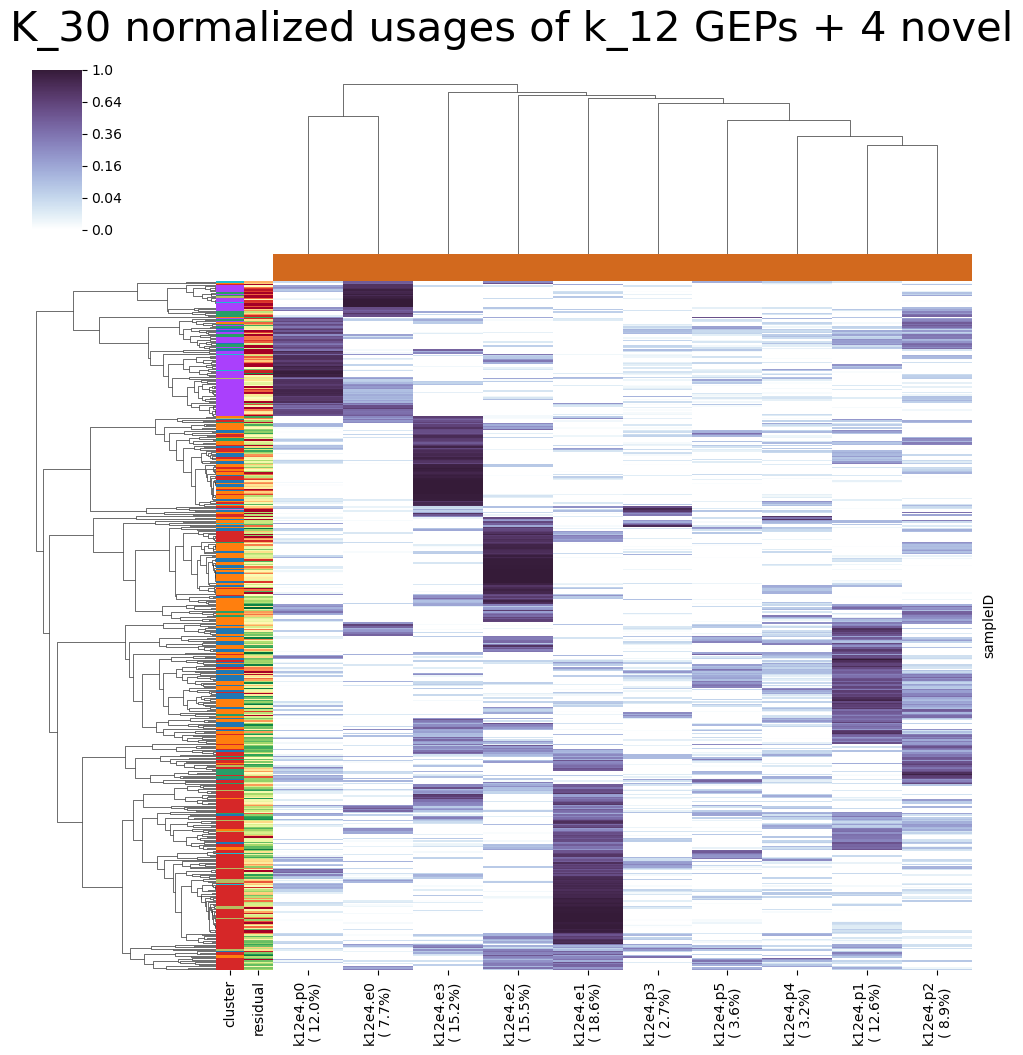

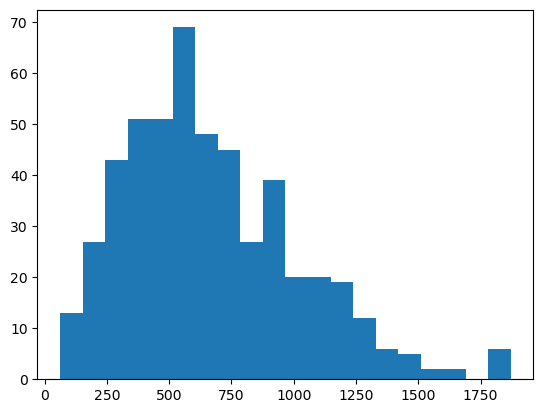

In [31]:
for name, ns in decompositions.items():
    if 'dn' in name:
        title = f'K_30 normalized usages of de-novo GEPs, k={ns.rank}'
    elif name == 'k12':
        title = f'K_30 normalized usages of k_12 GEPs (rank={ns.rank})'
    elif ns.algorithm == 'pfnmf':
        title = f'K_30 normalized usages of k_12 GEPs + {ns.rank - rank_k12} novel'
    
    row_colors = pd.concat([pd.Series(k_30.obsm.get('row_colors'), name='cluster', index=k_30.obs.index),
                       pd.Series(_utils.floats_to_colors(ns.loss_per_cell, cmap='RdYlGn_r', vmax=1200), name='residual', index=k_30.obs.index)], axis=1)
    
    un_sns = _utils.plot_usages_norm_clustermaps(k_30, normalized_usages=ns.norm_usages,
        columns=ns.prog_labels_2l, title=title, show=True, sns_clustermap_params={
            'col_colors': [coloring_scheme[name]] * ns.rank, 'row_colors': row_colors})
    
    plt.hist(ns.loss_per_cell, bins=20)
    plt.show()
    plt.close()

In [32]:
decompositions.keys()

dict_keys(['dn_6', 'dn_7', 'dn_8', 'dn_9', 'dn_10', 'k12', 'k12e1', 'k12e2', 'k12e3', 'k12e4'])

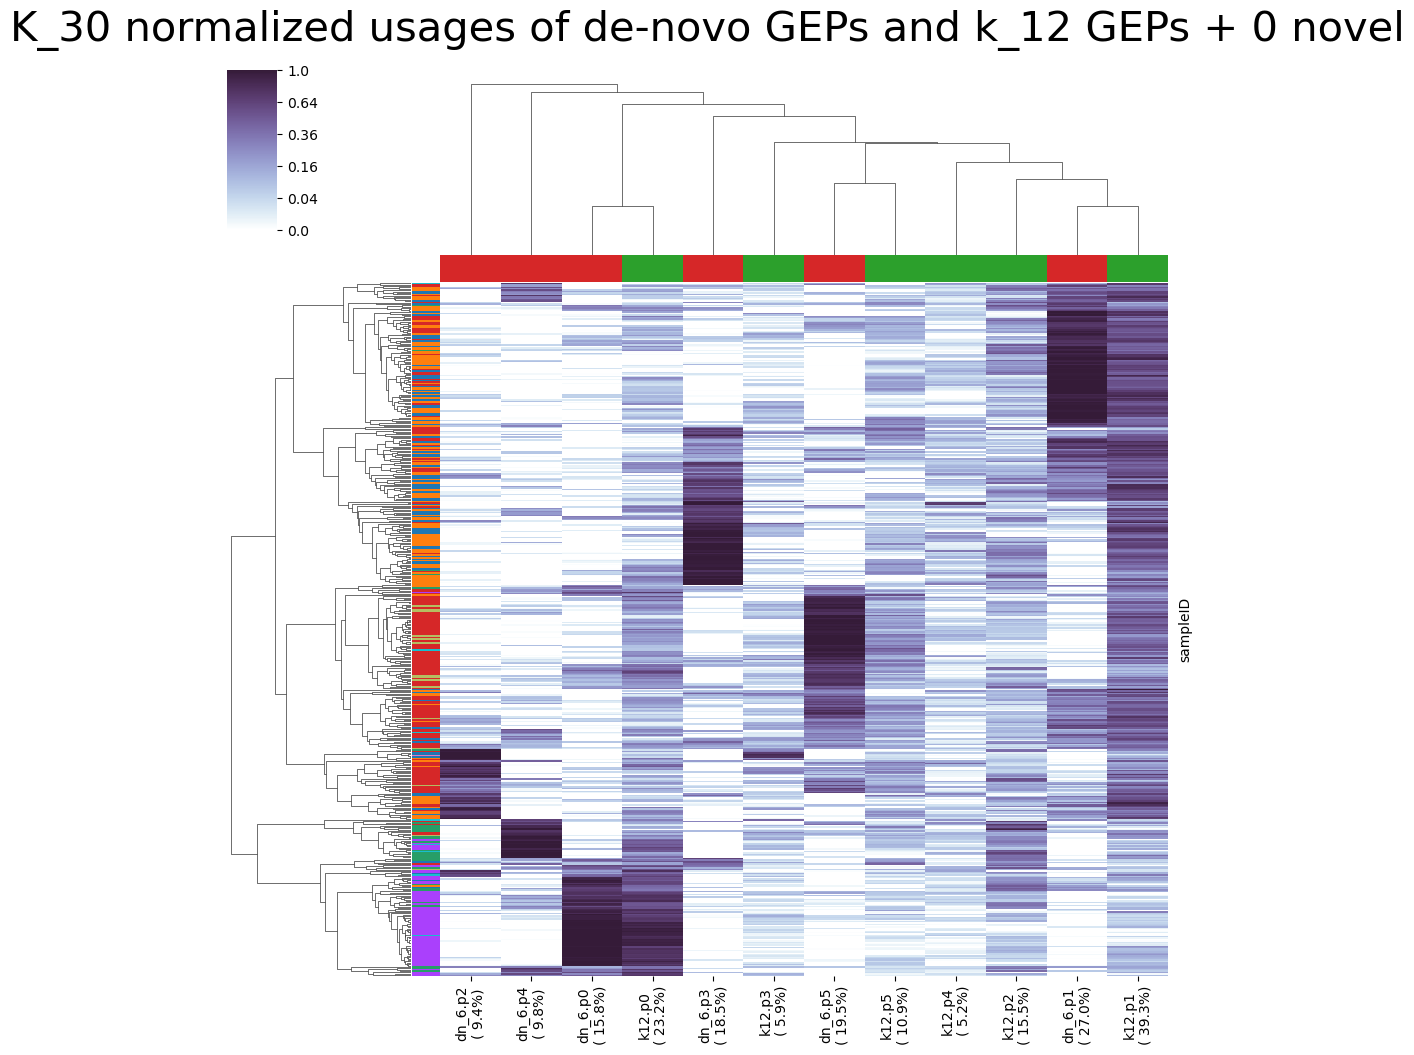

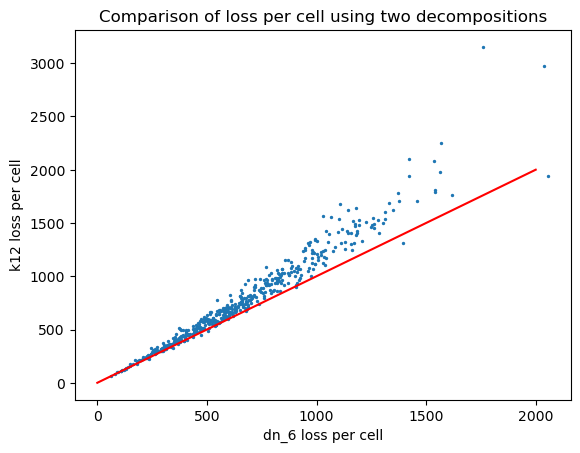

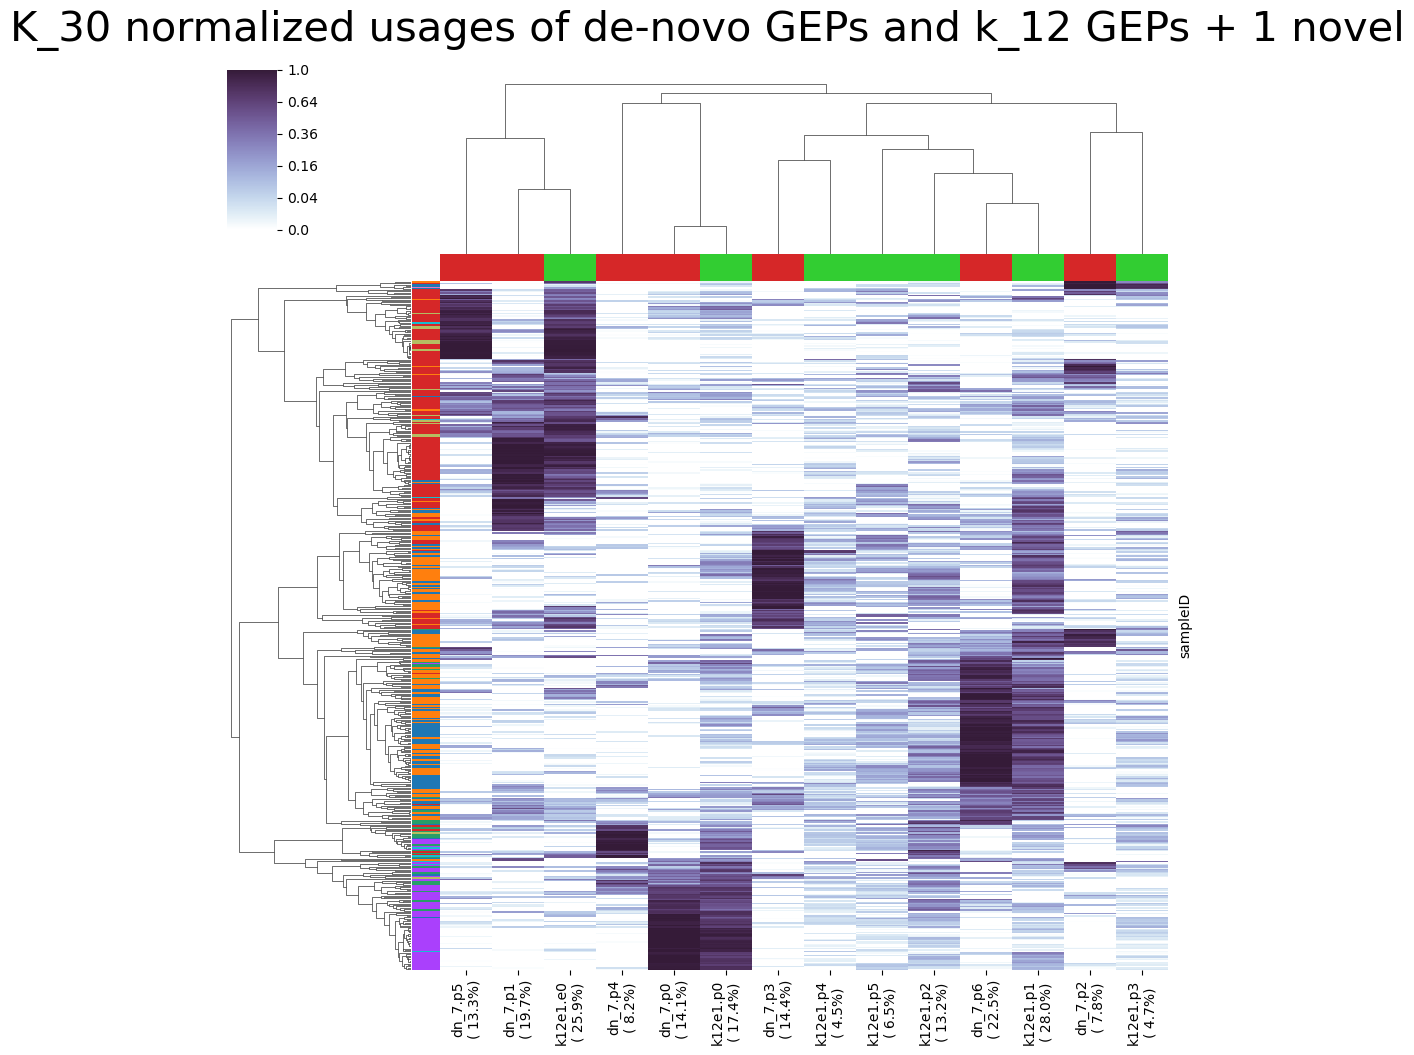

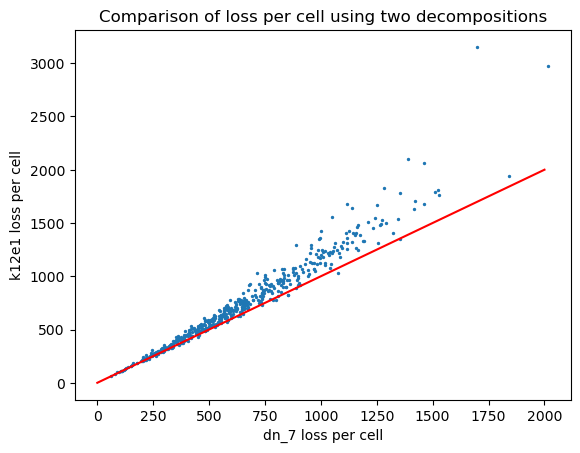

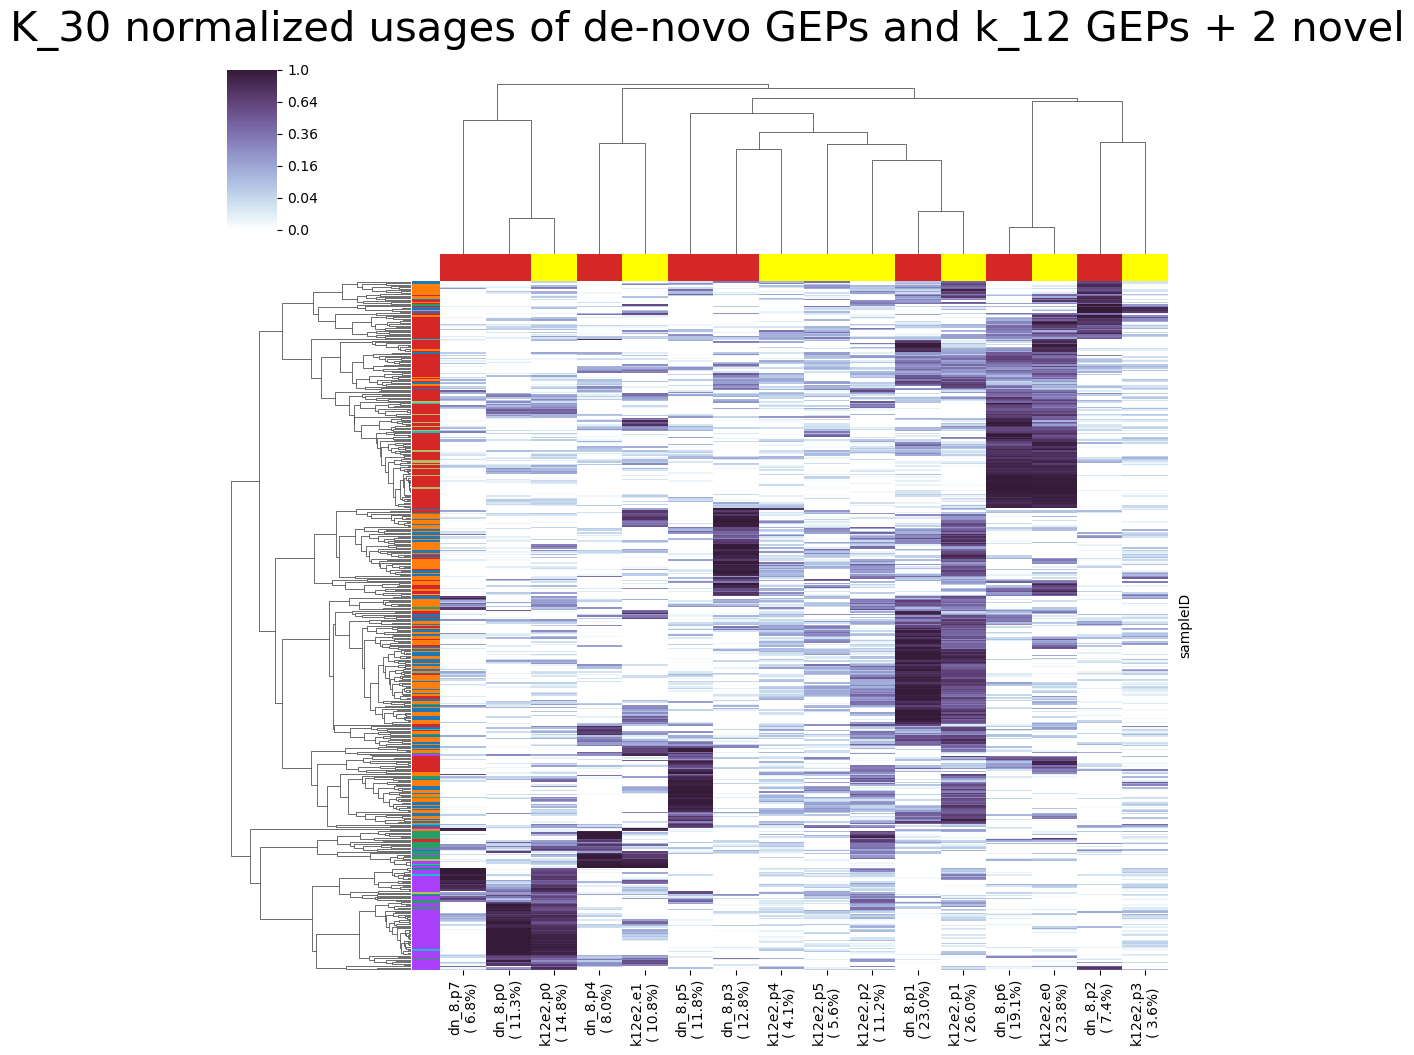

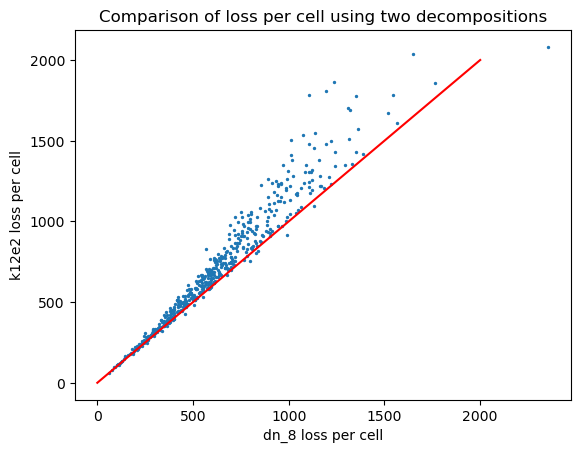

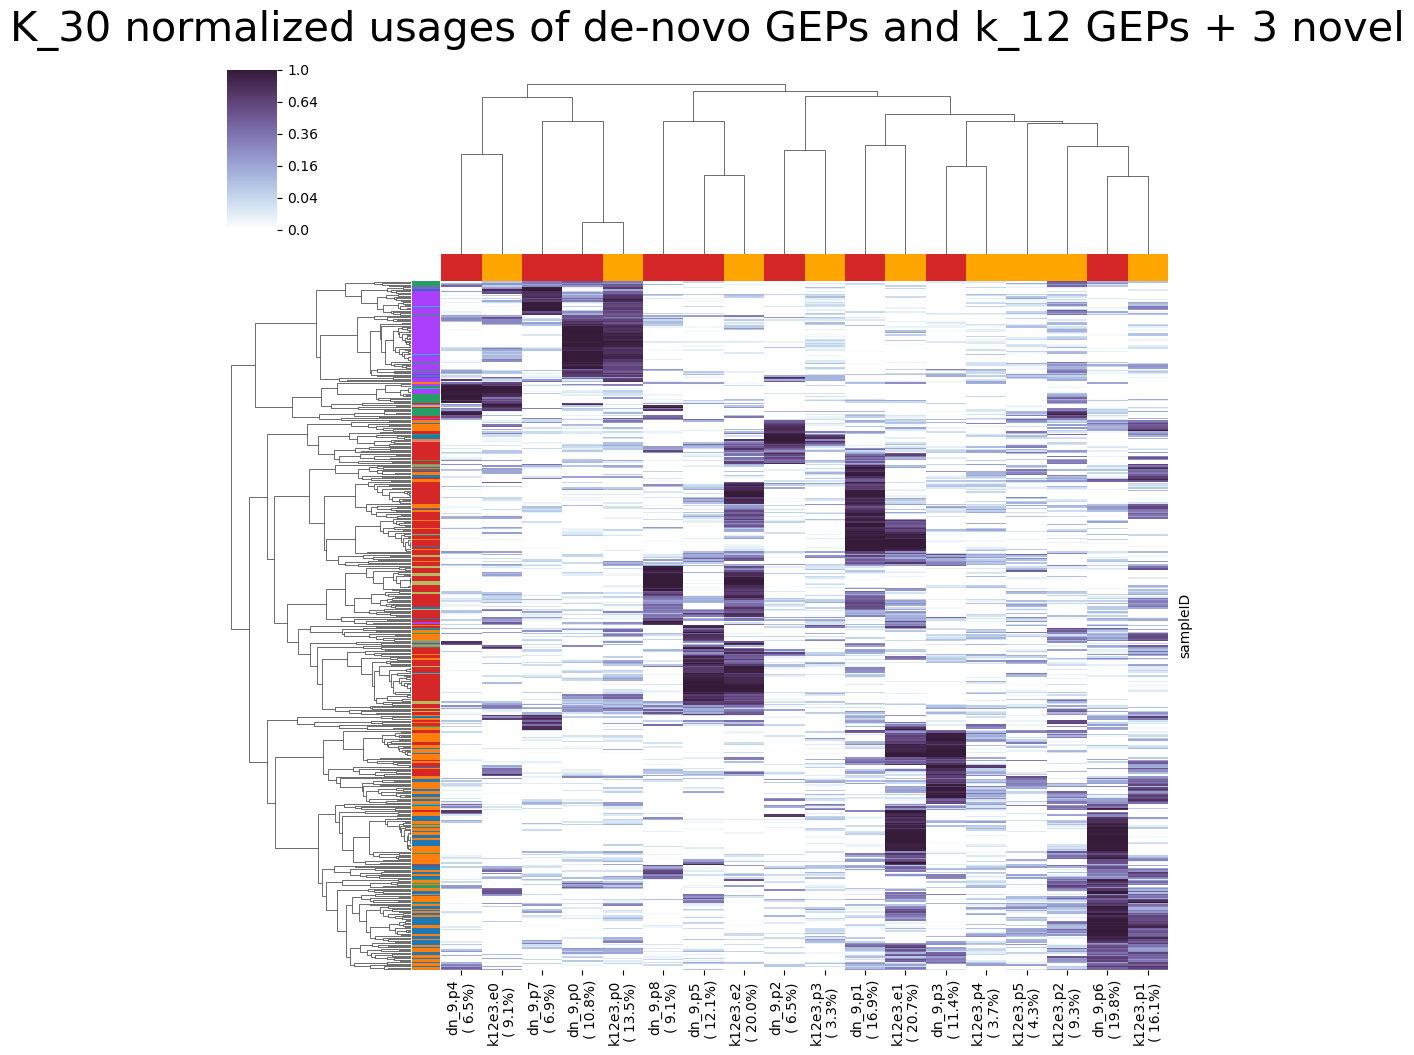

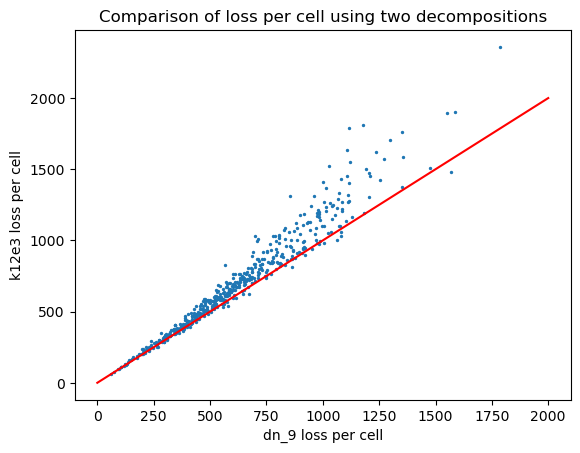

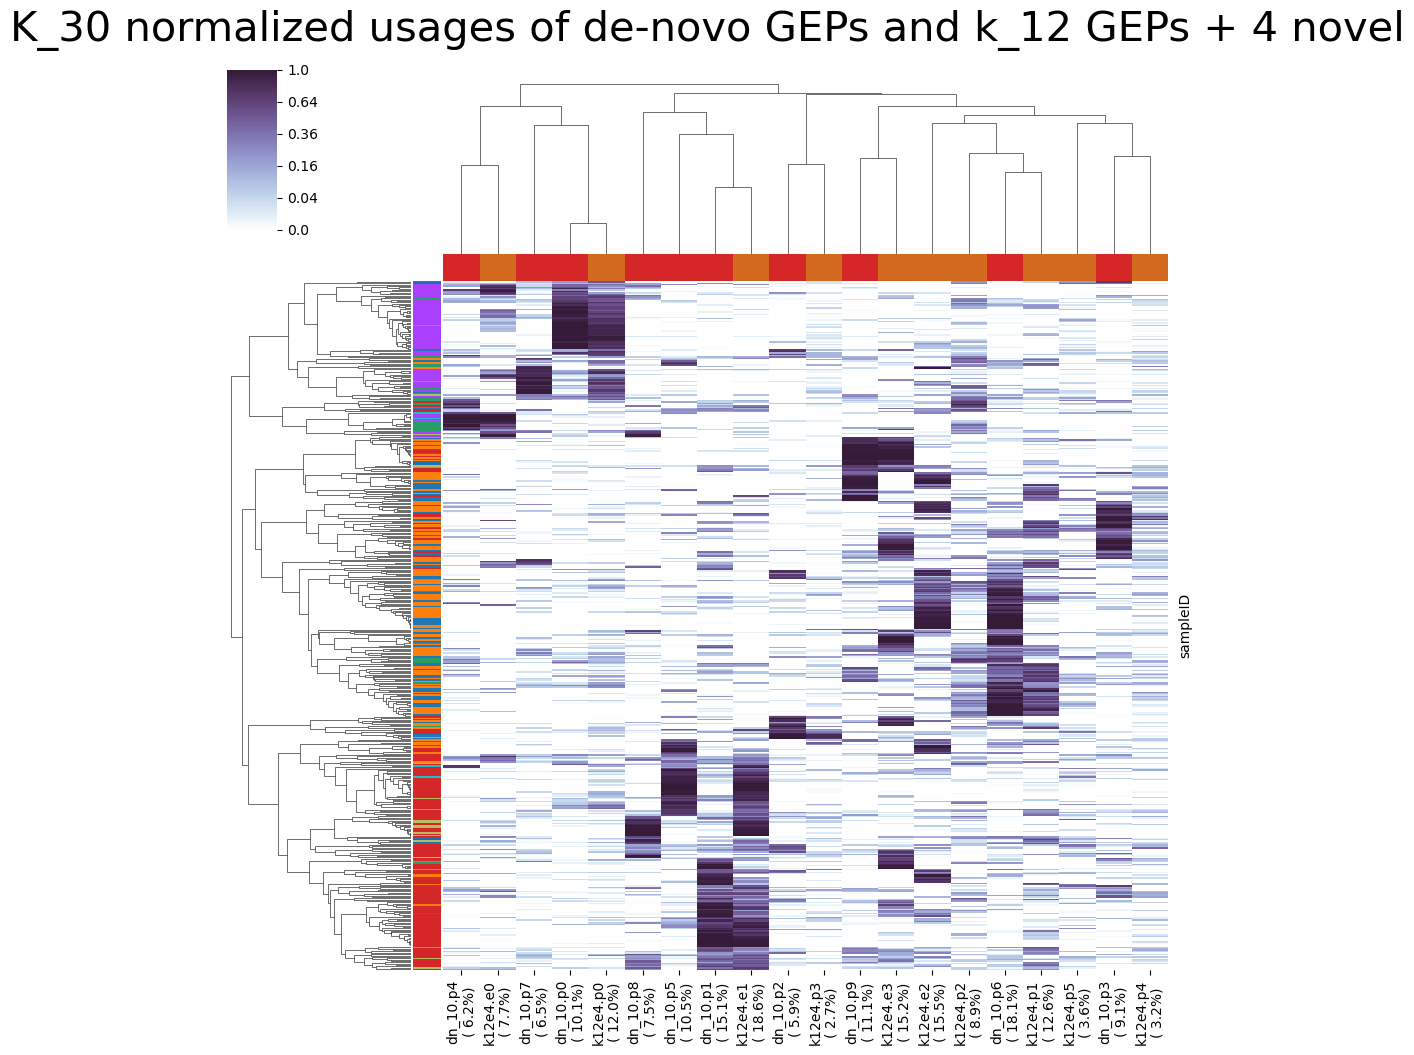

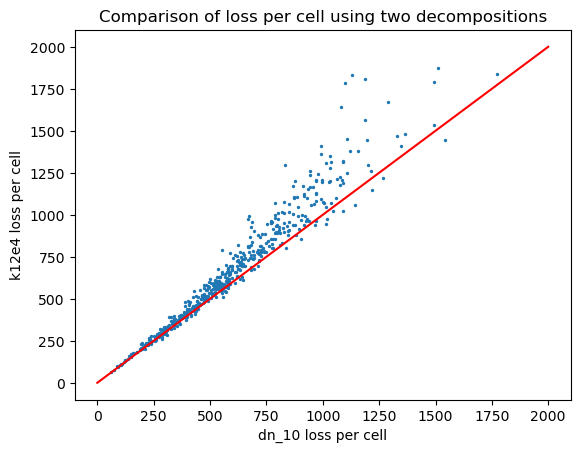

In [33]:

for dn_name, pf_name in zip(['dn_6', 'dn_7', 'dn_8', 'dn_9', 'dn_10'],
                                ['k12', 'k12e1', 'k12e2', 'k12e3', 'k12e4']):
    ns0 = decompositions[dn_name]
    ns1 = decompositions[pf_name]
    
    title = f'K_30 normalized usages of de-novo GEPs and k_12 GEPs + {ns1.rank - rank_k12} novel'

    joint_usages = np.concatenate([ns0.norm_usages, ns1.norm_usages], axis=1)

    joint_labels = ns0.prog_labels_2l + ns1.prog_labels_2l

    joint_colors = [coloring_scheme[dn_name]] * ns0.rank + [coloring_scheme[pf_name]] * ns1.rank

    un_sns = _utils.plot_usages_norm_clustermaps(
        k_30, normalized_usages=joint_usages, columns=joint_labels,
        title=title, show=True, sns_clustermap_params={'col_colors': joint_colors})
    
    plt.plot([0, 2000], [0, 2000], 'r-')
    plt.scatter(ns0.loss_per_cell, ns1.loss_per_cell, s=2)
    plt.xlabel(f'{dn_name} loss per cell')
    plt.ylabel(f'{pf_name} loss per cell')
    plt.title('Comparison of loss per cell using two decompositions')
    plt.show()
    plt.close()

In [34]:
def aggregate_ns_fields(ns_dict, key_list):
    ks = [ns_dict[key].rank for key in key_list]
    
    joint_prog_names = []
    for key in key_list:
        joint_prog_names.extend(ns_dict[key].prog_names.copy())
    
    joint_usages = ns_dict[key_list[0]].norm_usages.copy()
    joint_labels = ns_dict[key_list[0]].prog_labels_1l.copy()
    joint_colors = [coloring_scheme[key_list[0]]] * ns_dict[key_list[0]].rank
    
    for key in key_list[1:]:
        joint_usages = np.concatenate([joint_usages, ns_dict[key].norm_usages.copy()], axis=1)

        joint_labels.extend(ns_dict[key].prog_labels_1l.copy())

        joint_colors.extend([coloring_scheme[key]] * ns_dict[key].rank)
    
    return ks, joint_prog_names, joint_usages, joint_labels, joint_colors



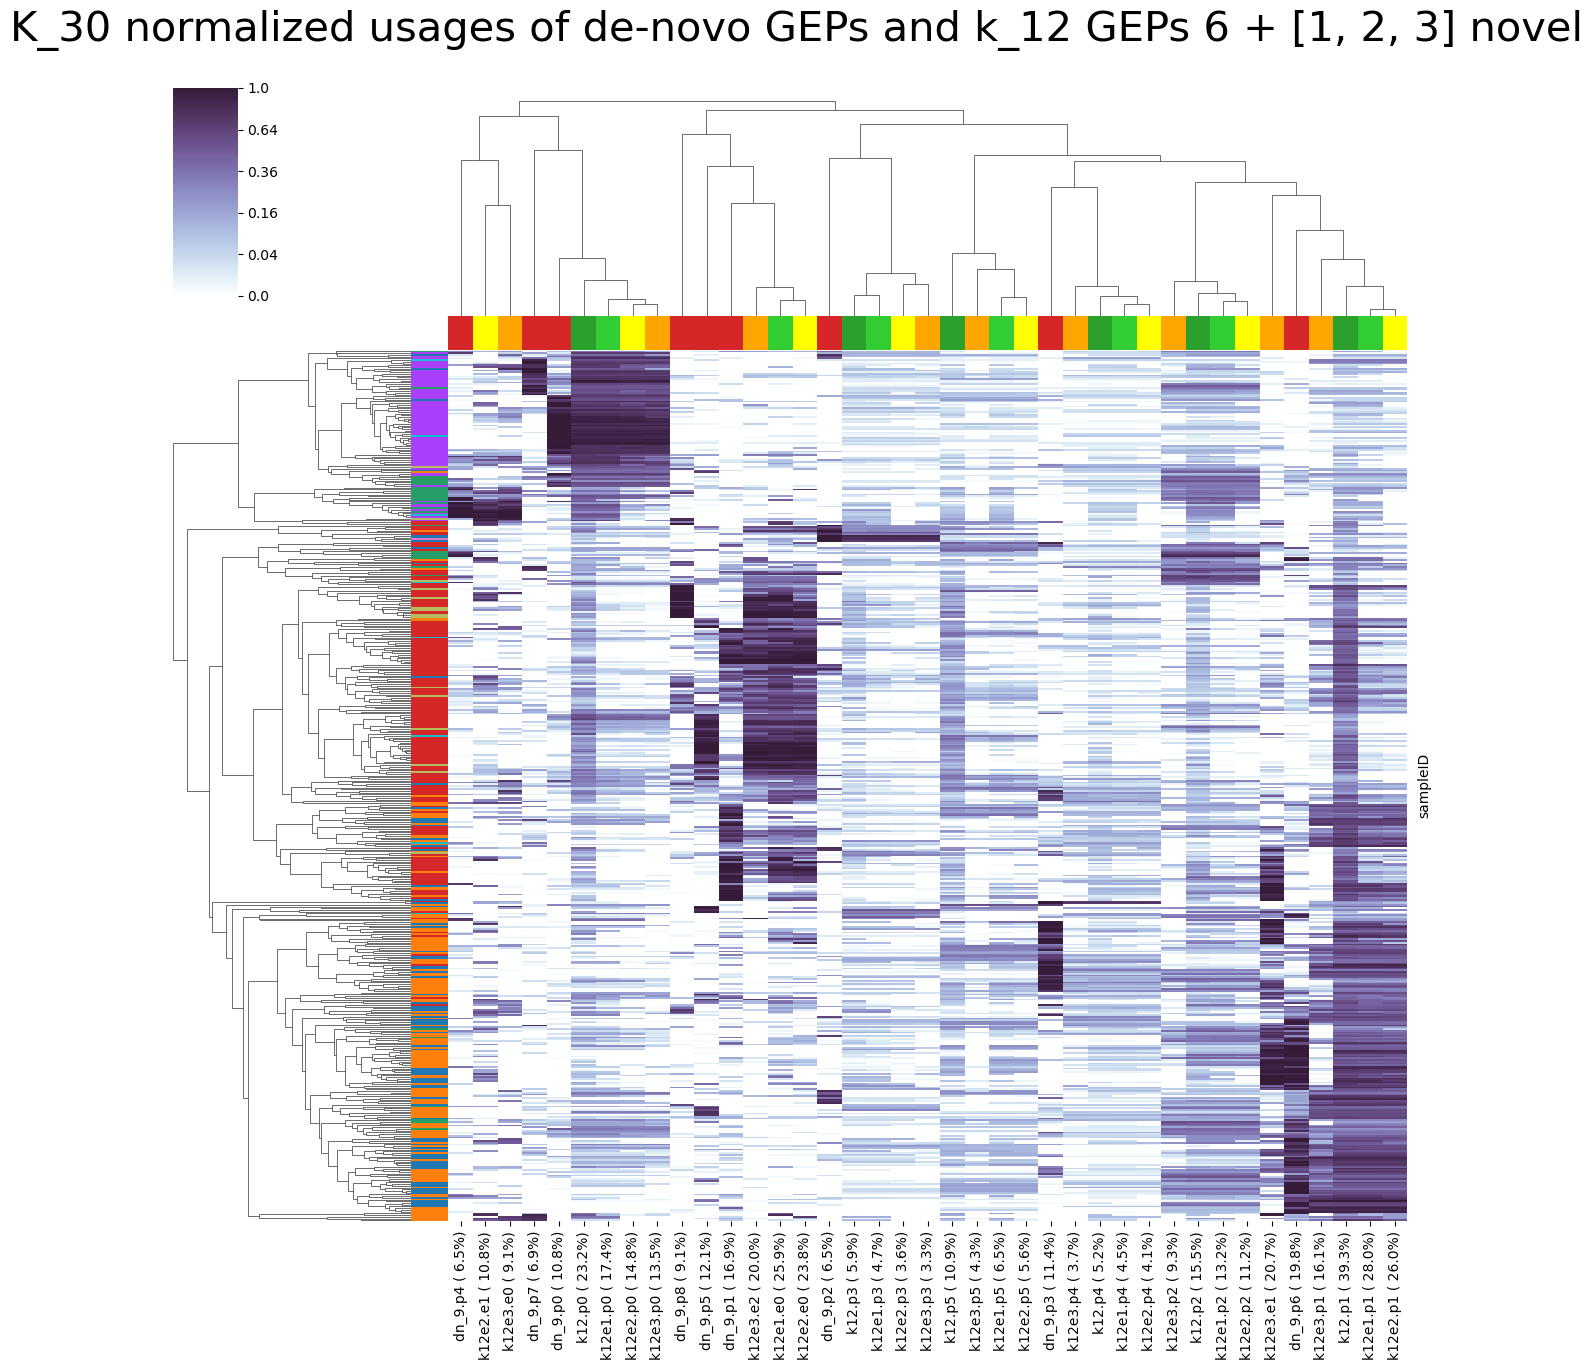

In [35]:
keys = ['k12', 'k12e1', 'k12e2', 'k12e3', 'dn_9']

ks, joint_prog_names, joint_usages, joint_labels, joint_colors = aggregate_ns_fields(decompositions, keys)


title = f'K_30 normalized usages of de-novo GEPs and k_12 GEPs {rank_k12} + [1, 2, 3] novel'

un_sns = _utils.plot_usages_norm_clustermaps(
    k_30, normalized_usages=joint_usages, columns=joint_labels, title=title,
    show=True, sns_clustermap_params={'col_colors': joint_colors, 'figsize': (13, 13)})



### Usages correlations

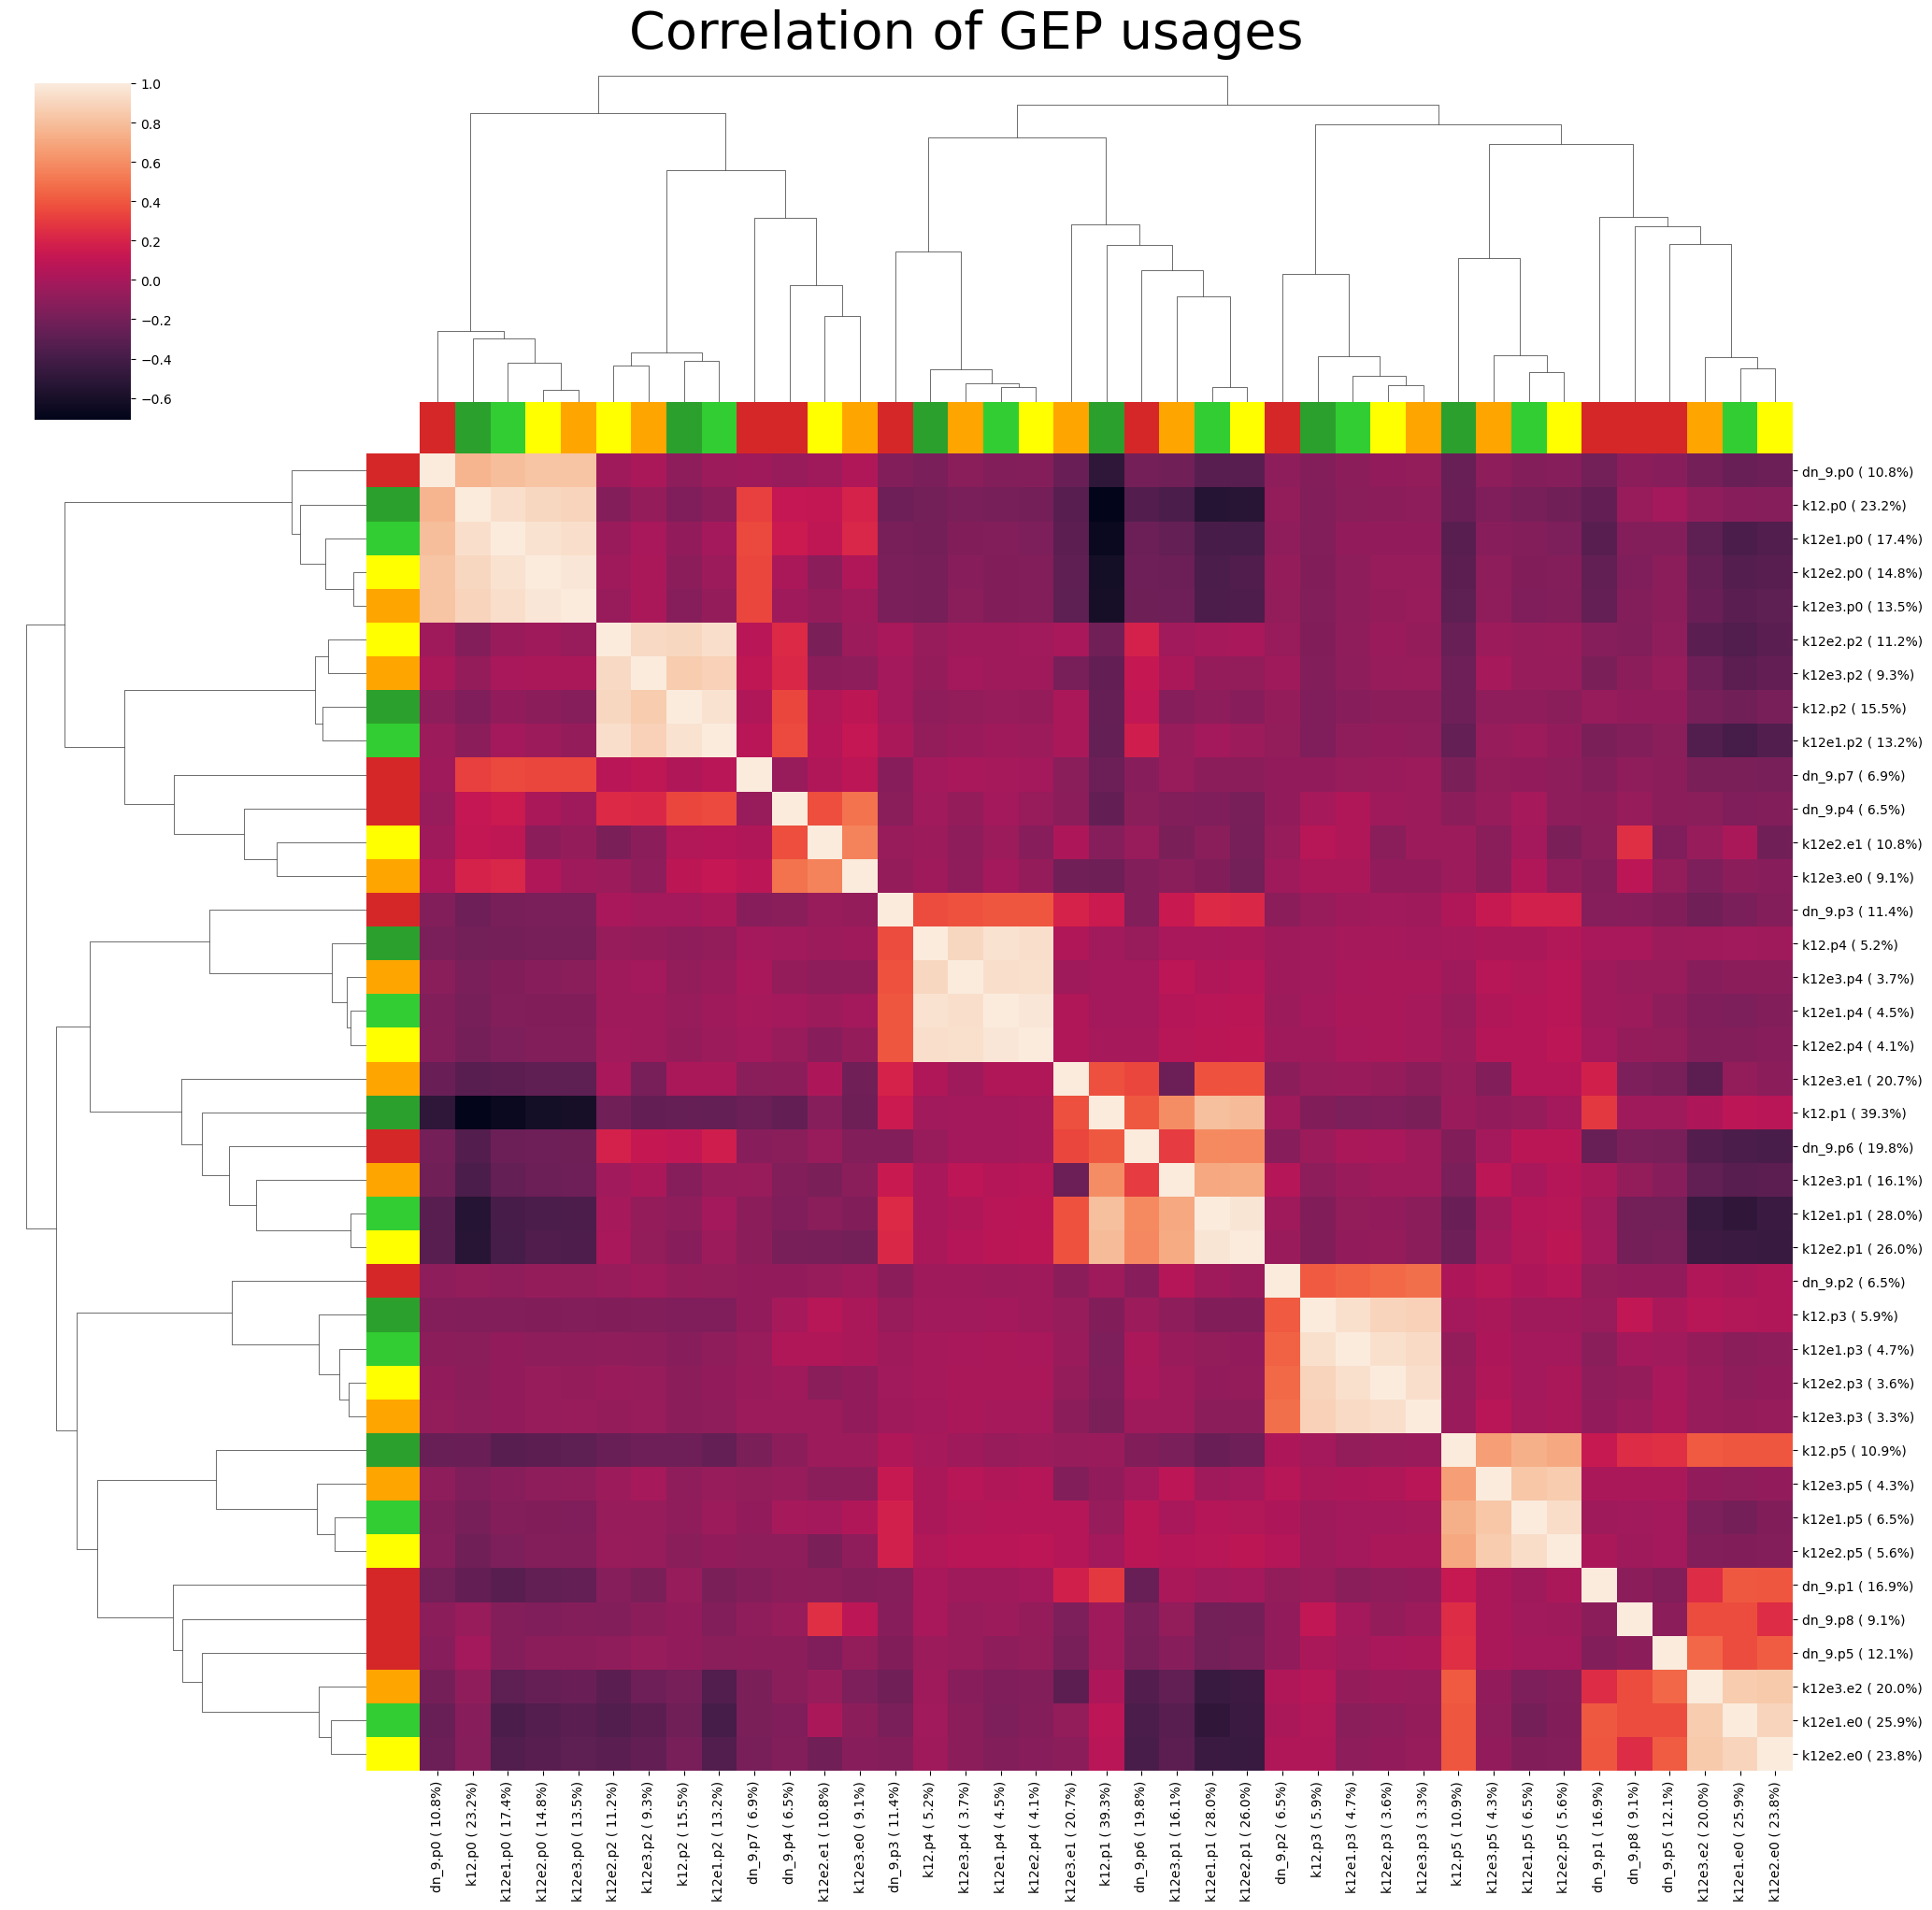

In [36]:
keys = ['k12', 'k12e1', 'k12e2', 'k12e3', 'dn_9']

ks, joint_prog_names, joint_usages, joint_labels, joint_colors = aggregate_ns_fields(decompositions, keys)

n_genes, n_programs = joint_usages.shape

# ranked_coefs = n_genes - rankdata(joint_usages, axis=0)
# ranked_coefs[ranked_coefs > (k_30.n_obs//2)] = (k_30.n_obs//2)
# spearman_corr = np.corrcoef(ranked_coefs, rowvar=False)

pearson_corr = np.corrcoef(joint_usages.T)

un_sns = _utils.sns.clustermap(pd.DataFrame(pearson_corr, index=joint_labels, columns=joint_labels),
                               figsize=(4 + n_programs * 0.43, 4 + n_programs * 0.41),
                               row_colors=joint_colors, col_colors=joint_colors)

un_sns.figure.suptitle('Correlation of GEP usages', fontsize=40, y=1.02)
plt.show()

In [37]:
# correlation graph functions

def get_ordered_adjacency_matrix(correlation_matrix, prog_names, ranks, threshold=0.2):
    # adjacency matrix creation
    adj_df = pd.DataFrame(np.round((correlation_matrix), 2),
                          index=prog_names,
                          columns=prog_names)
    
    # order
    linkage = hierarchy.linkage(
        adj_df, method='average', metric='euclidean')
    prog_order = hierarchy.leaves_list(
        hierarchy.optimal_leaf_ordering(linkage, adj_df))
    
    # keeping only edges between consecutive layers
    for i in range(len(ranks) - 2):
        adj_df.values[:np.sum(ranks[:i + 1]), np.sum(ranks[:i + 2]):] = 0
        adj_df.values[np.sum(ranks[:i + 2]):, :np.sum(ranks[:i + 1])] = 0

    np.fill_diagonal(adj_df.values, 0)
    adj_df.values[adj_df.values <= threshold] = 0
    
    print(f'Number of edges={np.count_nonzero(adj_df)}')

    # ordering the nodes for display
    adj_df = adj_df.iloc[prog_order, prog_order]
    
    return adj_df

def plot_layered_correlation_graph(layer_keys, adj_df, prog_names_dict, title,
                                   plt_figure_kwargs=None, fig_title_kwargs=None):
    
    # setting figure arguments
    figure_kwargs = {'figsize': (14.4, 16.2), 'dpi': 100}
    if plt_figure_kwargs is not None: figure_kwargs.update(plt_figure_kwargs)
    
    title_kwargs = {'fontsize': 25, 'y': 0.95}
    if fig_title_kwargs is not None: title_kwargs.update(fig_title_kwargs)

    
    # maping adata short name to layer number
    name_map = dict(zip(layer_keys, range(len(layer_keys))))

    # create the graph object
    G = nx.from_numpy_array(adj_df.values, create_using=nx.Graph)
    nx.relabel_nodes(G, lambda i: adj_df.index[i], copy=False)
    nx.set_node_attributes(
        G, {node: name_map[node.split('.')[0]] for node in G.nodes}, name='layer')

    # prepare graph for display
    layout = nx.multipartite_layout(G, subset_key='layer')

    edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
    edge_width = 15 * np.power(weights, 2)  # visual edge emphesis

    if len(layer_keys) > 2:
        for layer in {data['layer'] for key, data in G.nodes.data()}:
            nodes = [node for node in G.nodes if name_map[node.split('.')[0]] == layer]

            angles = np.linspace(-np.pi / 4, np.pi / 4, len(nodes))

            for i, node in enumerate(nodes):
                layout[node] = [layer + 2 * np.cos(angles[i]), np.sin(angles[i])]

    fig, ax = plt.subplots(1, 1, **figure_kwargs)
    nx.draw(G, layout, node_size=3000, with_labels=False, edge_color=weights,
            edge_vmin=threshold, edge_vmax=1., width=edge_width, ax=ax)

    cmp = plt.matplotlib.cm.ScalarMappable(plt.matplotlib.colors.Normalize(vmin=threshold, vmax=1))
    plt.colorbar(cmp, orientation='horizontal', cax=fig.add_subplot(18, 5, 86))

    # change color of layers
    for key in layer_keys:
        nx.draw_networkx_nodes(
            G, layout, node_color=coloring_scheme[key], node_size=2800,
            nodelist=prog_names_dict[key], ax=ax)
    nx.draw_networkx_labels(G, layout, font_size=11, ax=ax)
    
    plt.suptitle(title, **title_kwargs)

    plt.tight_layout()
    return fig

Number of edges=64


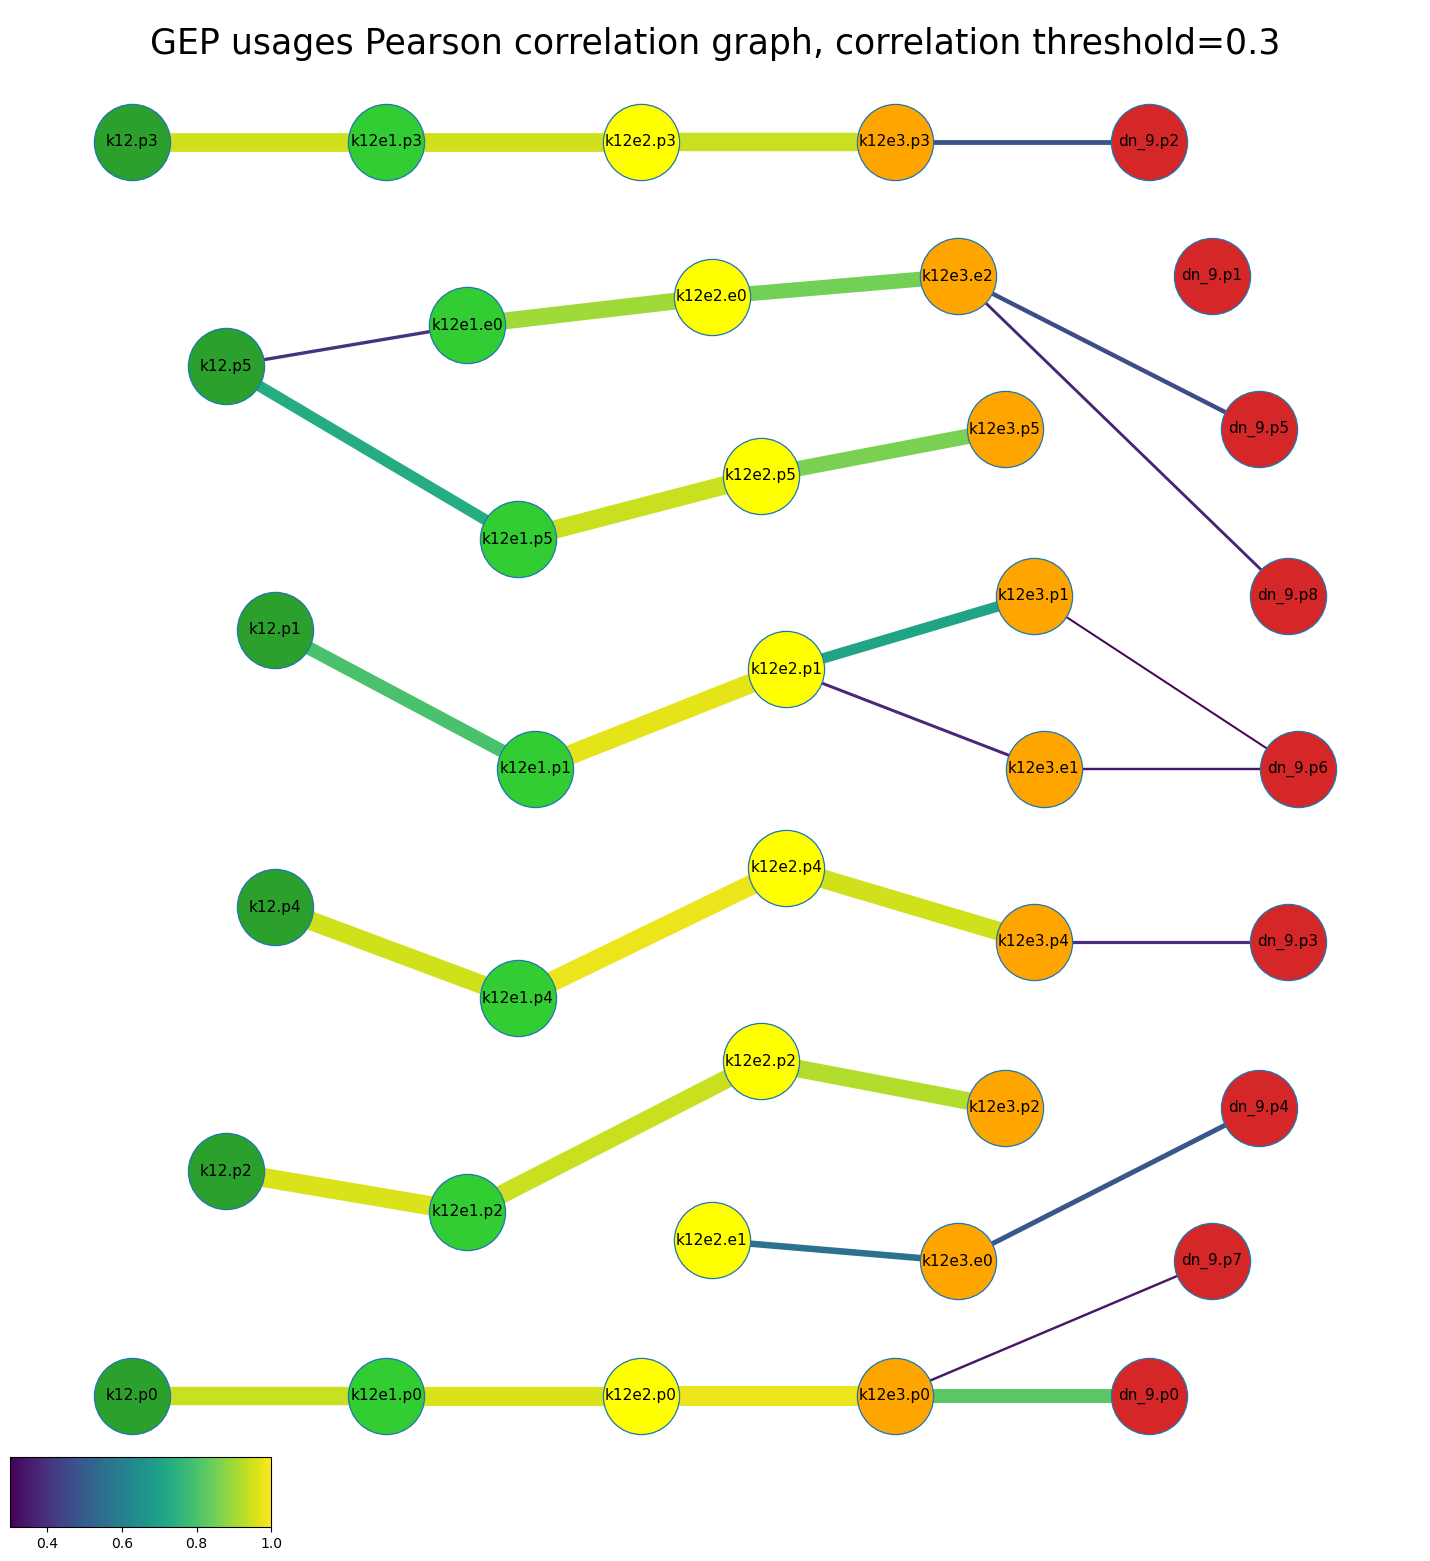

In [38]:
keys = ['k12', 'k12e1', 'k12e2', 'k12e3', 'dn_9']
threshold = 0.3

title = f'GEP usages Pearson correlation graph, correlation threshold={threshold}'

# aggregating data from the listed layers:
ks, joint_prog_names, joint_usages, joint_labels, joint_colors = aggregate_ns_fields(decompositions, keys)

prog_names_dict = {key: decompositions[key].prog_names for key in keys}

# Creating the relevant adjacency matrix, here based on pearson correlation
adj_df = get_ordered_adjacency_matrix(np.corrcoef(joint_usages.T), joint_prog_names, ks, threshold)

fig = plot_layered_correlation_graph(keys, adj_df, prog_names_dict, title)
plt.show()

Number of edges=10


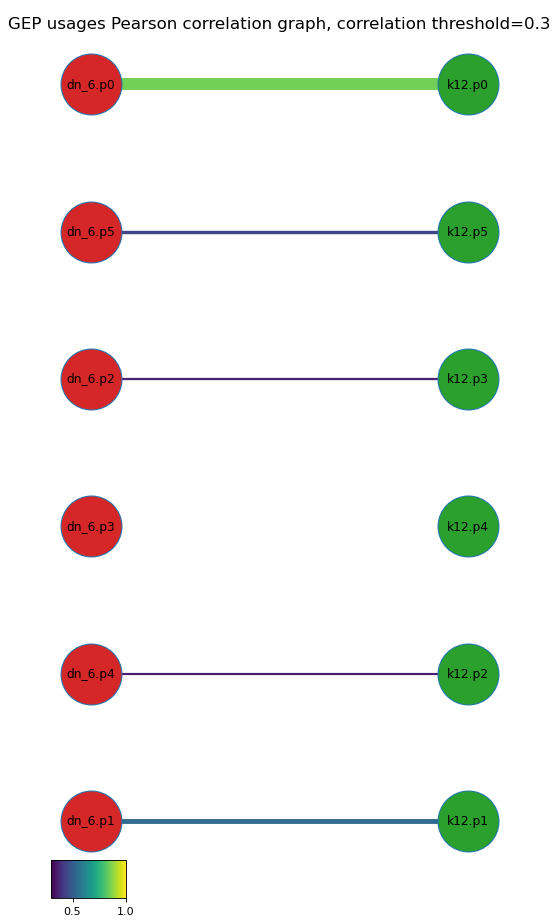

Number of edges=14


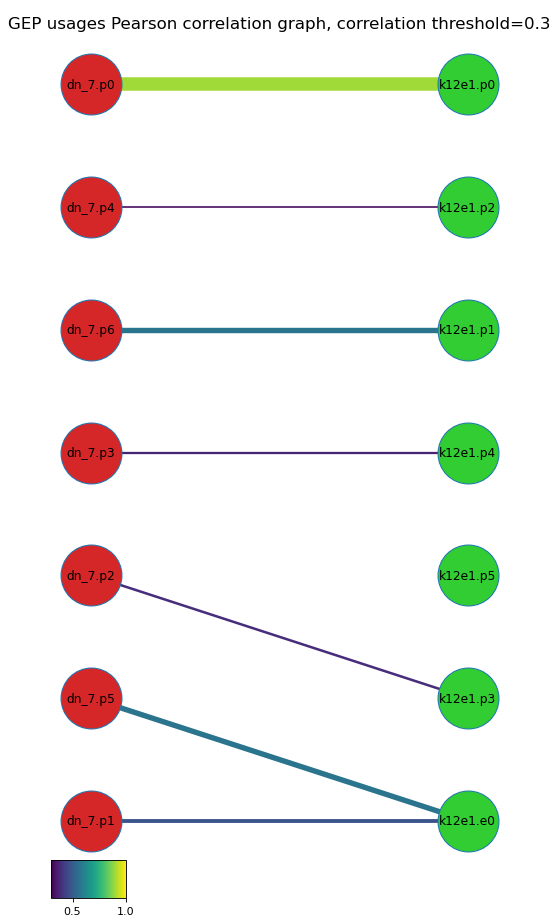

Number of edges=12


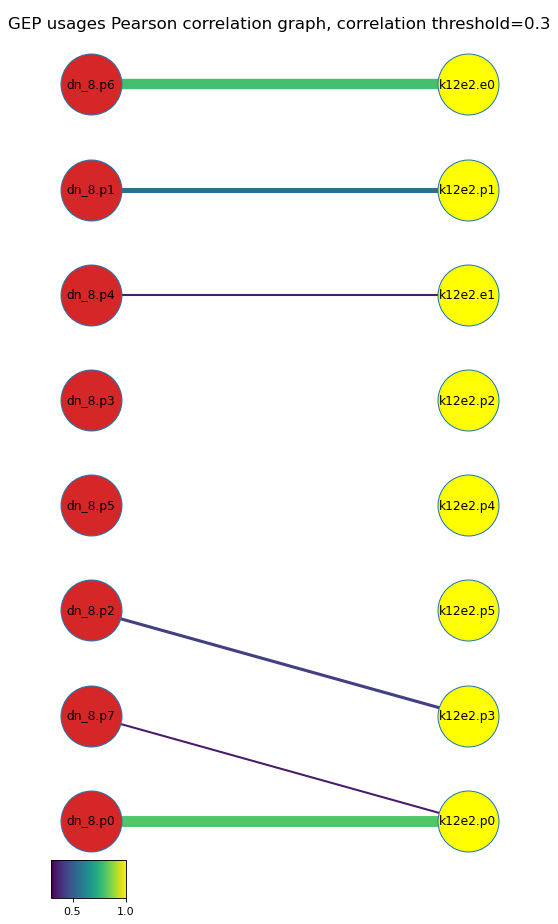

Number of edges=18


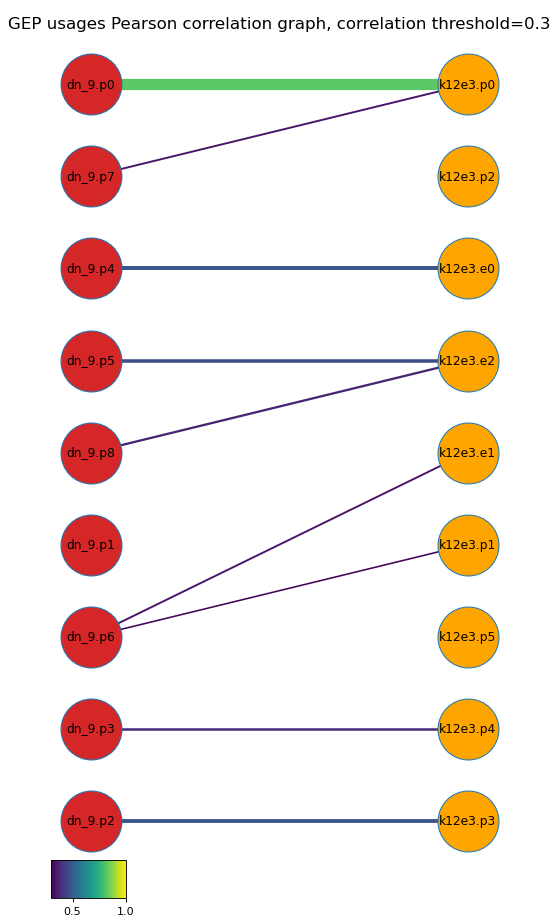

Number of edges=22


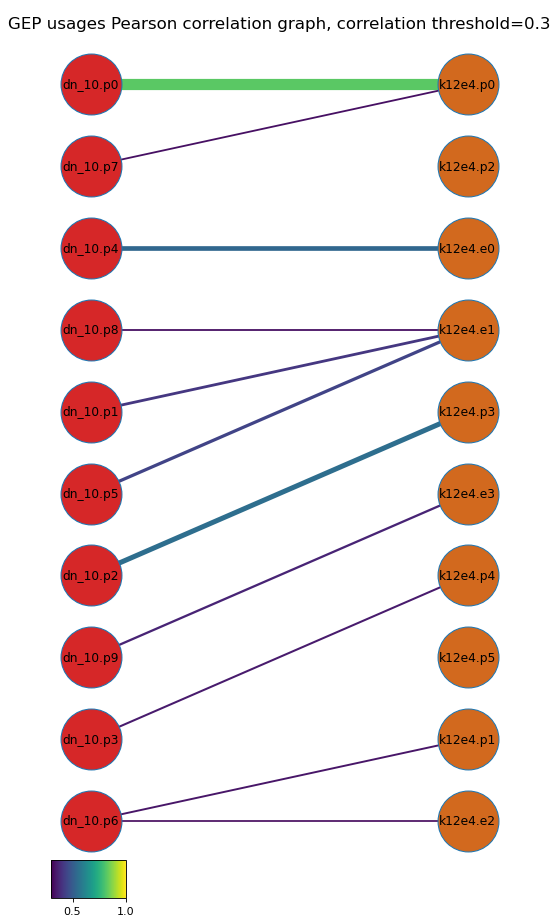

In [39]:
# keys = ['k12', 'dn_6', 'k12e1', 'dn_7', 'k12e2', 'dn_8', 'k12e3', 'dn_9']

threshold = 0.3
title = f'GEP usages Pearson correlation graph, correlation threshold={threshold}'

for dn_name, pf_name in zip(['dn_6', 'dn_7', 'dn_8', 'dn_9', 'dn_10'],
                                ['k12', 'k12e1', 'k12e2', 'k12e3', 'k12e4']):
    keys = [dn_name, pf_name]
    # aggregating data from the listed layers:
    ks, joint_prog_names, joint_usages, joint_labels, joint_colors = aggregate_ns_fields(decompositions, keys)

    prog_names_dict = {key: decompositions[key].prog_names for key in keys}

    # Creating the relevant adjacency matrix, here based on pearson correlation
    adj_df = get_ordered_adjacency_matrix(np.corrcoef(joint_usages.T), joint_prog_names, ks, threshold)

    fig = plot_layered_correlation_graph(keys, adj_df, prog_names_dict, title, {'figsize': (6, 12), 'dpi': 80}, {'fontsize': 15})
    plt.show(fig)
    plt.close(fig)
    


### Extracting usage coefficients over all genes

In [40]:
z_layer = 'cpm_log1p_zscore'

k_30.layers[z_layer] = sc.pp.normalize_total(k_30, target_sum=1e6, inplace=False)['X']
sc.pp.log1p(k_30, layer=z_layer)
sc.pp.scale(k_30, layer=z_layer)

In [41]:
for name, ns in decompositions.items():    
    ns.gene_coefs = pd.DataFrame(
        _utils.fastols(ns.norm_usages, k_30.layers[z_layer]).T,
        index=k_30.var.index,
        columns=ns.prog_names)

In [42]:
ns.gene_coefs

k12e4.p0  k12e4.p1  k12e4.p2  k12e4.p3  \
geneID                                                                    
ENSMUSG00000000001.4_Gnai3       0.533485 -0.165927 -0.063132  0.163228   
ENSMUSG00000000028.14_Cdc45     -0.152094 -0.209654 -0.139631  4.160989   
ENSMUSG00000000031.15_H19       -0.003079  0.216438  0.193404 -0.146078   
ENSMUSG00000000049.11_Apoh      -0.048394 -0.089532 -0.115166 -0.118512   
ENSMUSG00000000056.7_Narf       -0.040760 -0.149913  0.088457  0.408795   
...                                   ...       ...       ...       ...   
ENSMUSG00000114960.1_AC115289.2  0.062571 -0.098272 -0.252482 -0.168900   
ENSMUSG00000114967.1_AC161884.2  0.167118 -0.099263 -0.090254  0.488749   
ENSMUSG00000114968.1_AC130217.2 -0.166352 -0.124383 -0.107629 -0.073275   
kallistoKRASG12D_KRASG12D        0.373528 -0.449756  0.336589  0.879685   
tdTomato_tdTomato                1.279983 -0.226914  1.267427  0.227611   

                                 k12e4.p4  k12e4.p5  k12e4.e0  k12e4.e1  \
geneID                                                                    
ENSMUSG00000000001.4_Gnai3       0.363906 -0.487625  0.530312  0.204155   
ENSMUSG00000000028.14_Cdc45     -0.269926  0.226591  0.241497 -0.186705   
ENSMUSG00000000031.15_H19        0.110901 -0.322856 -0.097181 -0.069262   
ENSMUSG00000000049.11_Apoh      -0.072026  0.079207 -0.057228 -0.058215   
ENSMUSG00000000056.7_Narf        0.157442  0.440343  0.368196  0.127216   
...                                   ...       ...       ...       ...   
ENSMUSG00000114960.1_AC115289.2  0.184381 -0.115202  0.010272 -0.086863   
ENSMUSG00000114967.1_AC161884.2 -0.288931 -0.357586 -0.192361 -0.041677   
ENSMUSG00000114968.1_AC130217.2 -0.207828 -0.117892  0.613182 -0.093693   
kallistoKRASG12D_KRASG12D        0.066455 -0.664316  0.037080  0.059788   
tdTomato_tdTomato               -0.432861 -1.955679  0.228742 -0.558094   

                                 k12e4.e2  k12e4.e3  
geneID                                               
ENSMUSG00000000001.4_Gnai3      -0.469284 -0.280293  
ENSMUSG00000000028.14_Cdc45     -0.182547 -0.065769  
ENSMUSG00000000031.15_H19        0.001525 -0.079391  
ENSMUSG00000000049.11_Apoh      -0.061401  0.359128  
ENSMUSG00000000056.7_Narf       -0.202174 -0.240290  
...                                   ...       ...  
ENSMUSG00000114960.1_AC115289.2  0.250644  0.043120  
ENSMUSG00000114967.1_AC161884.2 -0.082033  0.292194  
ENSMUSG00000114968.1_AC130217.2 -0.071972  0.258716  
kallistoKRASG12D_KRASG12D       -0.279483  0.056630  
tdTomato_tdTomato               -0.114970 -0.376103  

[30999 rows x 10 columns]

### Running GO

In [43]:
gp = _utils.MyGProfiler(organism='hsapiens', sources=['GO:BP', 'WP', 'REAC', 'KEGG'])

genes_list = adata.var.loc[k_30.var.index, 'geneSymbol'].to_list()

In [66]:
%%script --no-raise-error false

# GSEA on the gene coefficients over K_12 data

program_go_dir = _utils.set_dir(notebook_dir.joinpath('programs_GSEA'))

for index in range(k_12.varm['usage_coefs'].shape[1]):
    ordered_genes_index = k_12.varm['usage_coefs'].nlargest(
        columns=[k_12.varm['usage_coefs'].columns[index]], n=1000).index

    ordered_genes = k_12.var.loc[ordered_genes_index, 'geneSymbol'].to_list()

    go_enrichment = gp.profile( 
        ordered_genes, ordered=True, background=adata.var.loc[k_12.var.index, 'geneSymbol'].to_list())

    go_enrichment.to_csv(
        program_go_dir.joinpath(f"{k_12.varm['usage_coefs'].columns[index]}.csv"))

In [44]:
%%script --no-raise-error false

program_go_dir = _utils.set_dir(notebook_dir.joinpath('programs_GSEA'))

for name, ns in decompositions.items():    
    for index in range(ns.rank):
        ordered_genes_index = ns.gene_coefs.nlargest(
            columns=[ns.prog_names[index]], n=1000).index
        
        ordered_genes = adata.var.loc[ordered_genes_index, 'geneSymbol'].to_list()
        
        go_enrichment = gp.profile( 
            ordered_genes, ordered=True, background=genes_list)

        go_enrichment.to_csv(
            program_go_dir.joinpath(f"{ns.prog_names[index]}.csv"))



In [45]:
joint_HVG_geneID = set(joint_K12_K30_var[joint_K12_K30_var.highly_variable].index)
k_30_HVG_geneID = set(k_30.var[k_30.var.highly_variable].index)
union_HVG_geneID = k_30_HVG_geneID.union(joint_HVG_geneID)

for name, ns in decompositions.items():    
    for index in range(ns.rank):
        ordered_geneID = set(ns.gene_coefs.nlargest(
            columns=[ns.prog_names[index]], n=1000).index)
        print(ns.prog_names[index],
              len(set.intersection(ordered_geneID, joint_HVG_geneID)),
              len(set.intersection(ordered_geneID, k_30_HVG_geneID)),
              len(set.intersection(ordered_geneID, union_HVG_geneID))
             )

dn_6.p0 191 244 270
dn_6.p1 101 121 162
dn_6.p2 160 117 221
dn_6.p3 134 102 179
dn_6.p4 153 174 229
dn_6.p5 90 131 143
dn_7.p0 190 243 270
dn_7.p1 97 130 155
dn_7.p2 156 117 223
dn_7.p3 131 95 175
dn_7.p4 164 190 246
dn_7.p5 100 131 158
dn_7.p6 113 148 190
dn_8.p0 192 229 261
dn_8.p1 96 127 164
dn_8.p2 150 118 218
dn_8.p3 143 84 176
dn_8.p4 163 181 235
dn_8.p5 112 77 152
dn_8.p6 90 135 148
dn_8.p7 158 159 212
dn_9.p0 190 225 256
dn_9.p1 95 107 141
dn_9.p2 149 125 220
dn_9.p3 128 98 172
dn_9.p4 166 196 256
dn_9.p5 97 107 138
dn_9.p6 101 138 175
dn_9.p7 146 148 204
dn_9.p8 101 115 154
dn_10.p0 185 225 254
dn_10.p1 92 105 132
dn_10.p2 149 125 220
dn_10.p3 142 92 184
dn_10.p4 160 186 245
dn_10.p5 87 104 131
dn_10.p6 108 132 176
dn_10.p7 145 151 201
dn_10.p8 108 102 150
dn_10.p9 114 89 154
k12.p0 185 235 260
k12.p1 74 118 141
k12.p2 126 150 191
k12.p3 126 126 202
k12.p4 150 108 200
k12.p5 86 112 132
k12e1.p0 190 242 268
k12e1.p1 85 127 160
k12e1.p2 119 138 178
k12e1.p3 126 129 206
k12e1.p4 

In [ ]:
%%script --no-raise-error false

program_go_dir = _utils.set_dir(notebook_dir.joinpath('programs_GSEA_HVG'))

for name, ns in decompositions.items():    
    for index in range(ns.rank):
        ordered_genes_index = ns.gene_coefs.nlargest(
            columns=[ns.prog_names[index]], n=1000).index
        
        ordered_genes_index = ordered_genes_index[ordered_genes_index.isin(joint_HVG_geneID)]
        
        ordered_genes = adata.var.loc[ordered_genes_index, 'geneSymbol'].to_list()
        
        go_enrichment = gp.profile( 
            ordered_genes, ordered=True, background=genes_list)

        go_enrichment.to_csv(
            program_go_dir.joinpath(f"{ns.prog_names[index]}.csv"))
        
#         break
#     break
# go_enrichment

### Calculating truncated spearman correlation

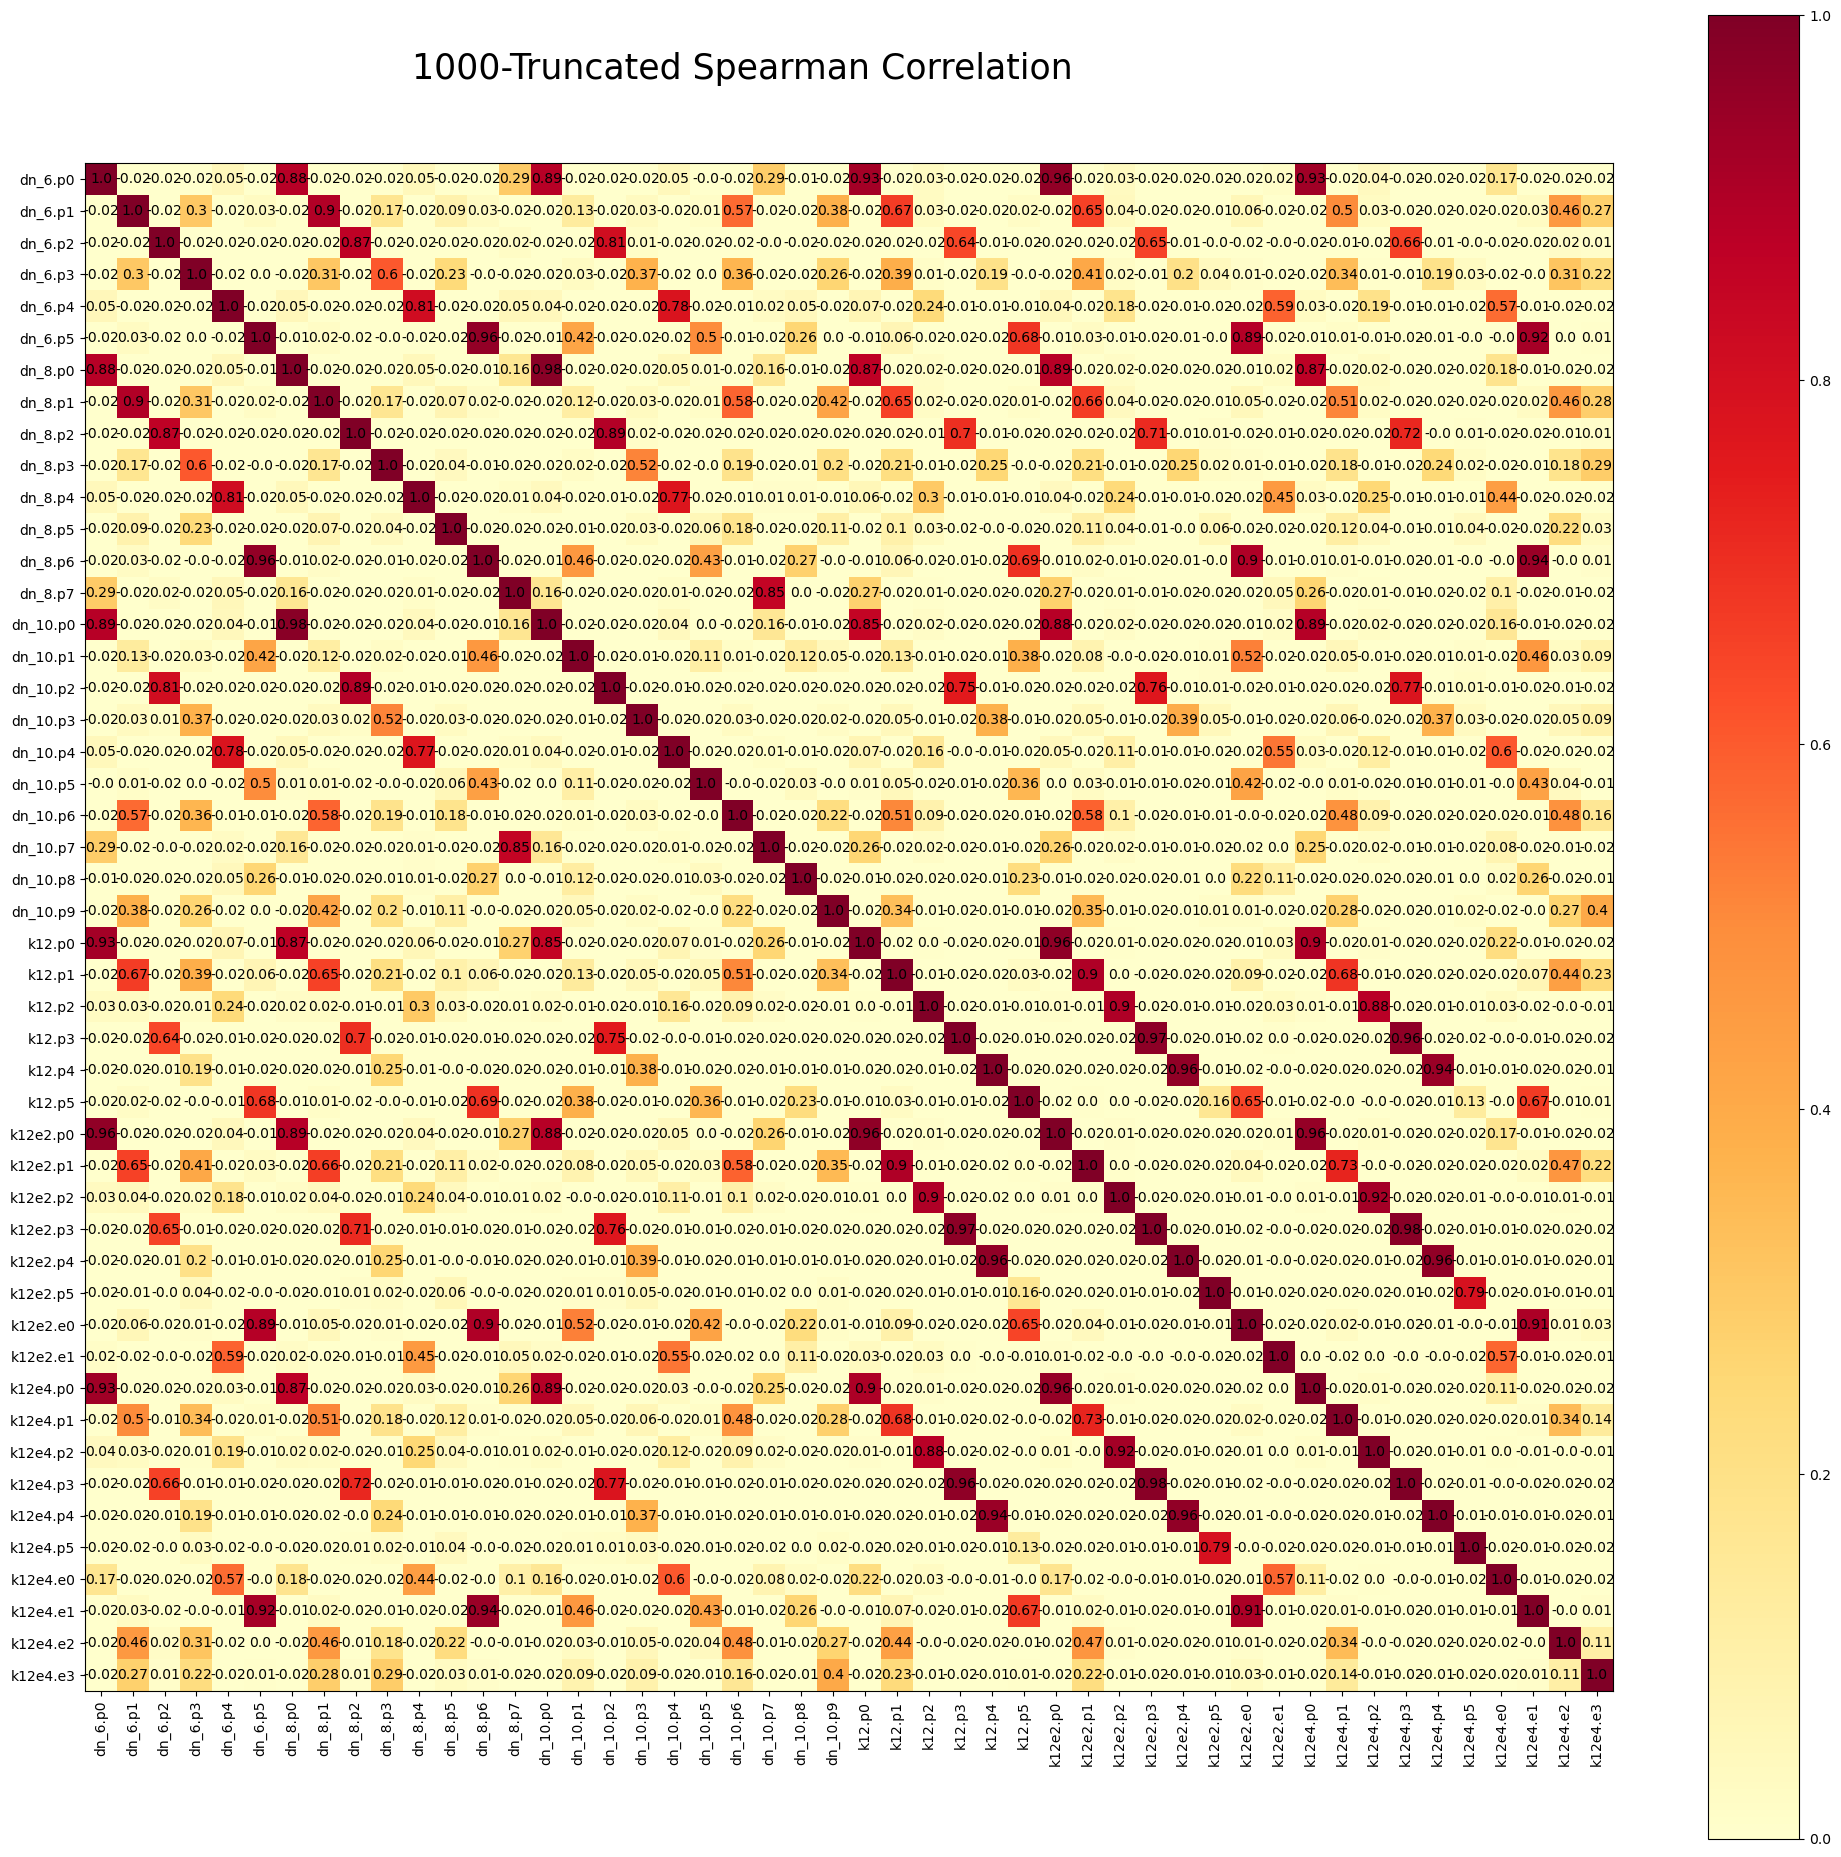

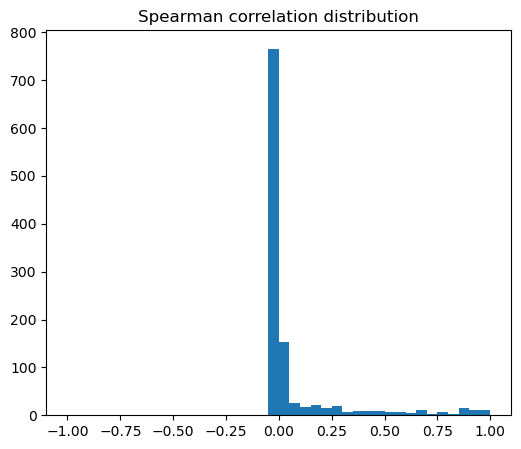

In [53]:
keys = ['dn_6', 'dn_8', 'dn_10', 'k12', 'k12e2', 'k12e4']

concatenated_spectras = pd.concat([
    decompositions[key].gene_coefs.copy() for key in keys], axis=1)

n_genes, n_programs = concatenated_spectras.shape

ranked_coefs = n_genes - rankdata(concatenated_spectras, axis=0)
ranked_coefs[ranked_coefs > _constants.N_COMPARED_RANKED] = _constants.N_COMPARED_RANKED
spearman_corr = np.corrcoef(ranked_coefs, rowvar=False)

# spearman figure
fig, ax = plt.subplots(figsize=(4 + ranked_coefs.shape[1] * 0.43,
                                4 + ranked_coefs.shape[1] * 0.41))

_utils.heatmap_with_numbers(
    spearman_corr, ax=ax, param_dict={'vmin': 0, 'vmax': 1})

ax.xaxis.tick_bottom()
ax.set_xticklabels(concatenated_spectras.columns, rotation='vertical')
ax.set_yticklabels(concatenated_spectras.columns)
ax.set_title(f'{_constants.N_COMPARED_RANKED}-Truncated Spearman Correlation',
             size=25, y=1.05, x=0.43)

plt.show(fig)

# fig.savefig(RESULTS_DIR.joinpath(
#     f'correlation_spearman_{utils.N_COMPARED_RANKED}_truncated.png'),
#     dpi=180, bbox_inches='tight')

# plt.close(fig)

# correlation histogram
fig, ax = plt.subplots(figsize=(6, 5))

plt.hist(spearman_corr[np.triu_indices_from(spearman_corr, k=1)],
         bins=np.linspace(-1, 1, 41))
ax.set_title('Spearman correlation distribution')
plt.show()

# fig.savefig(RESULTS_DIR.joinpath('correlation_histogtam_pearson.png'),
#             dpi=180, bbox_inches='tight')

# plt.close(fig)



Number of edges=88


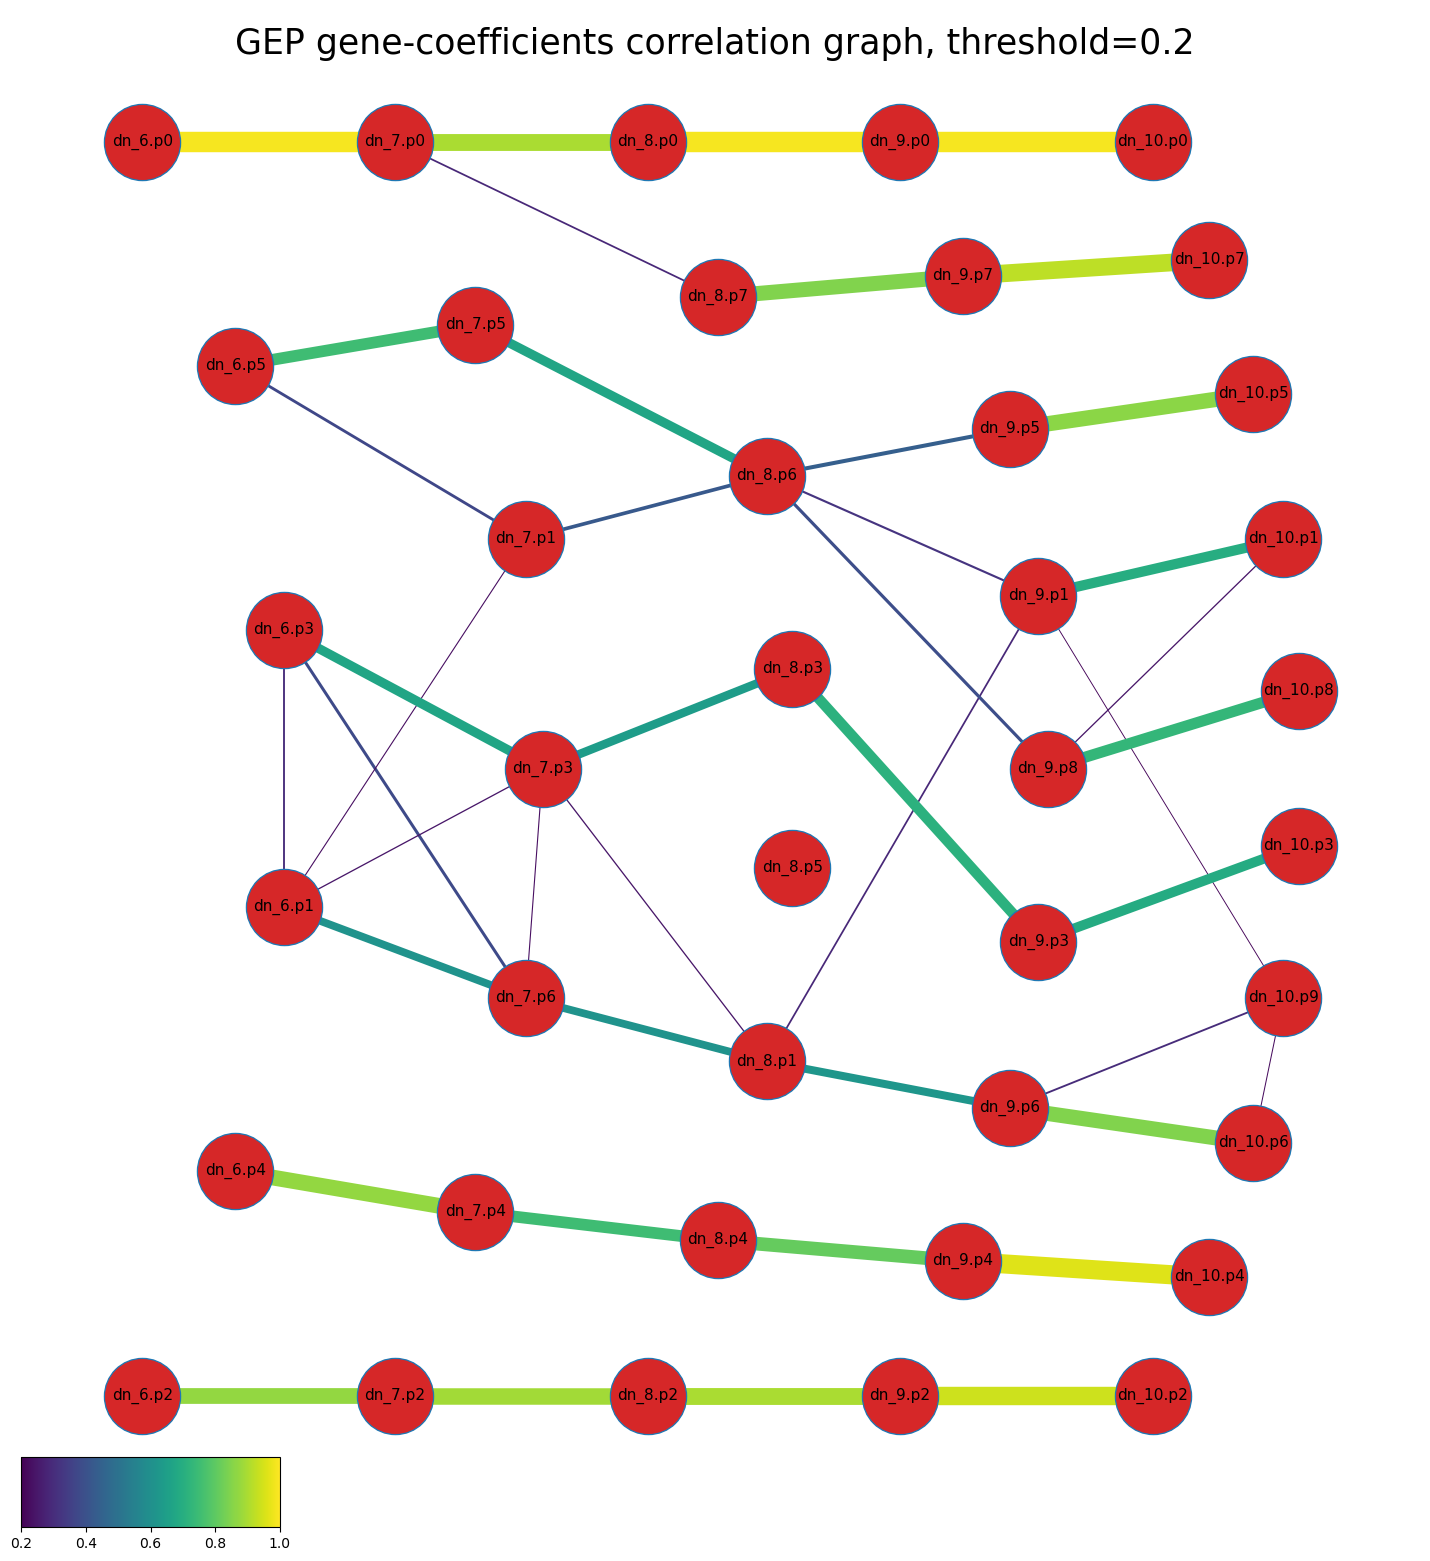

Number of edges=72


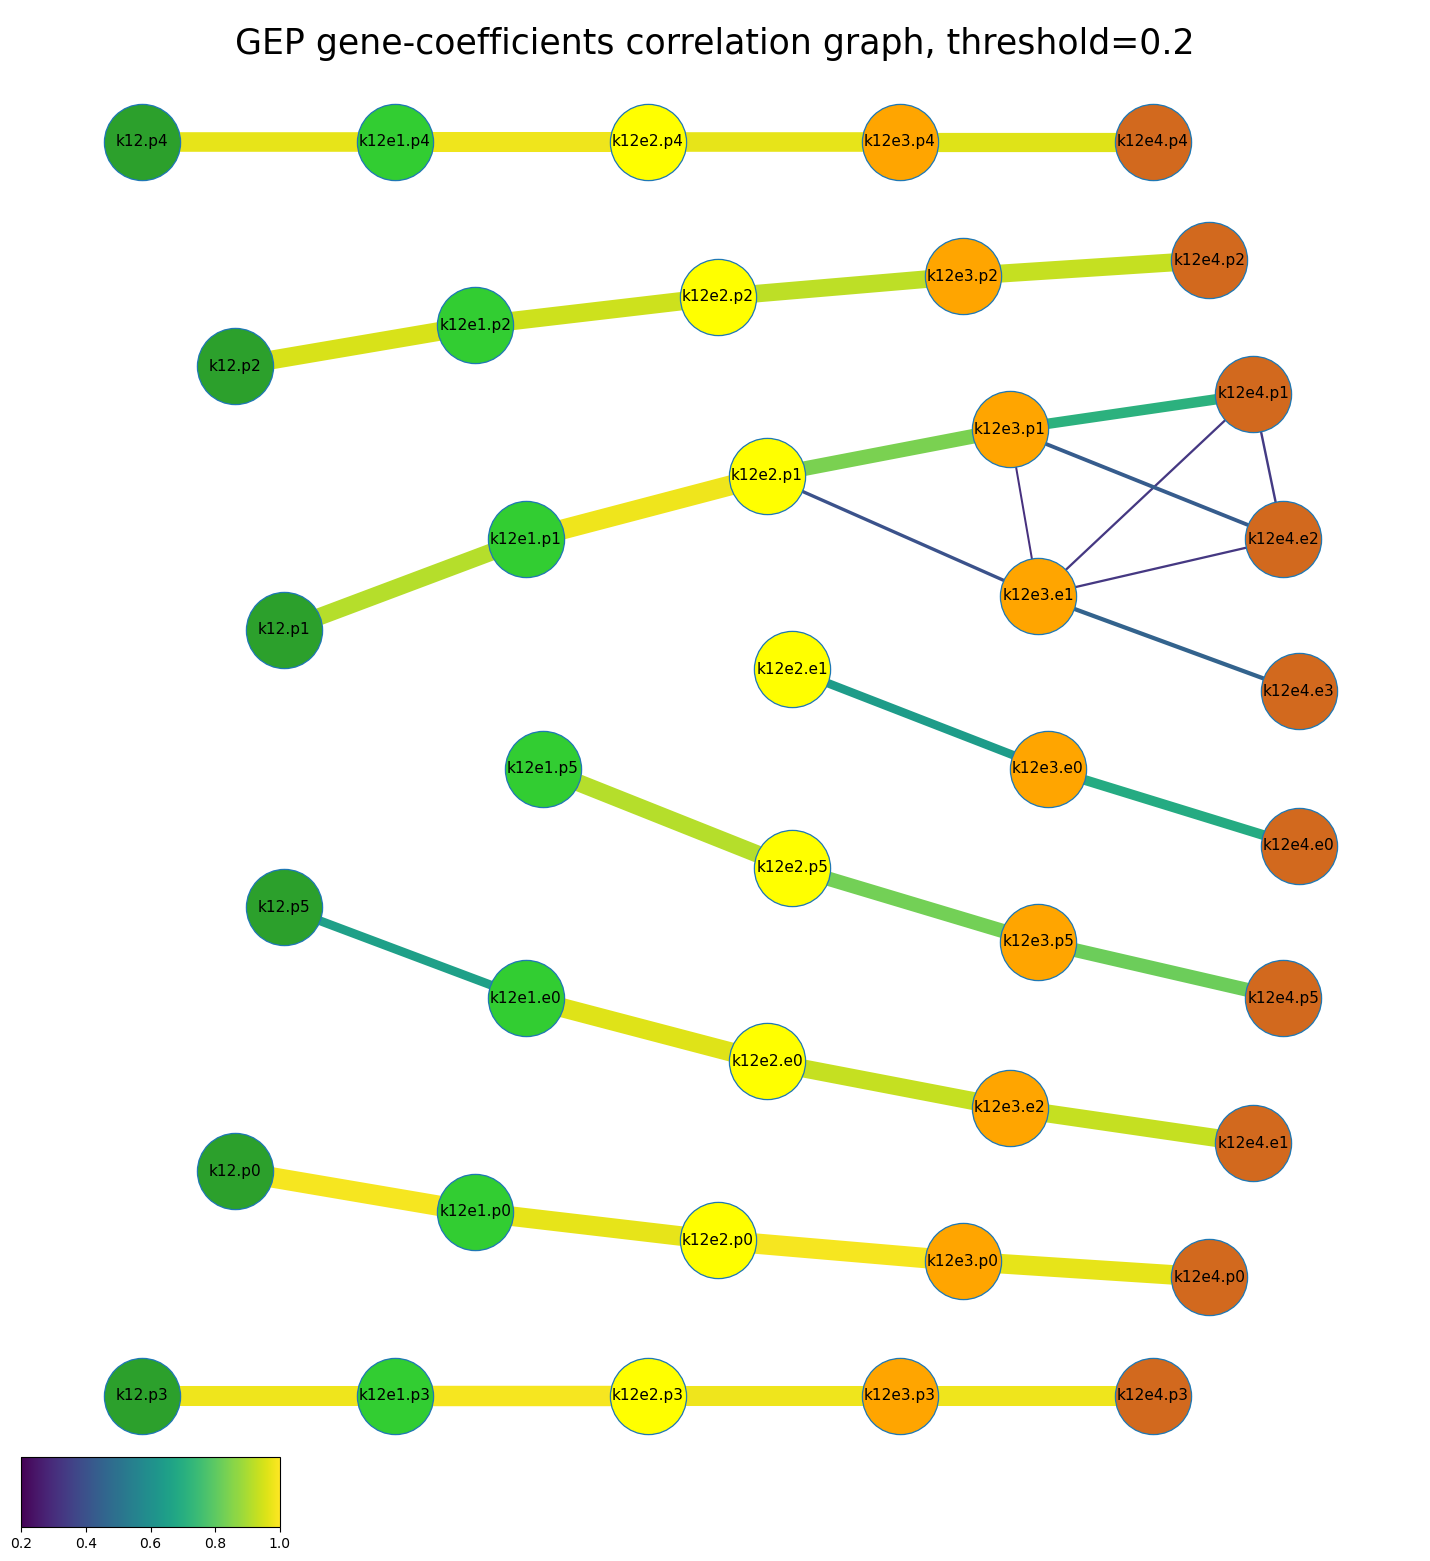

Number of edges=130


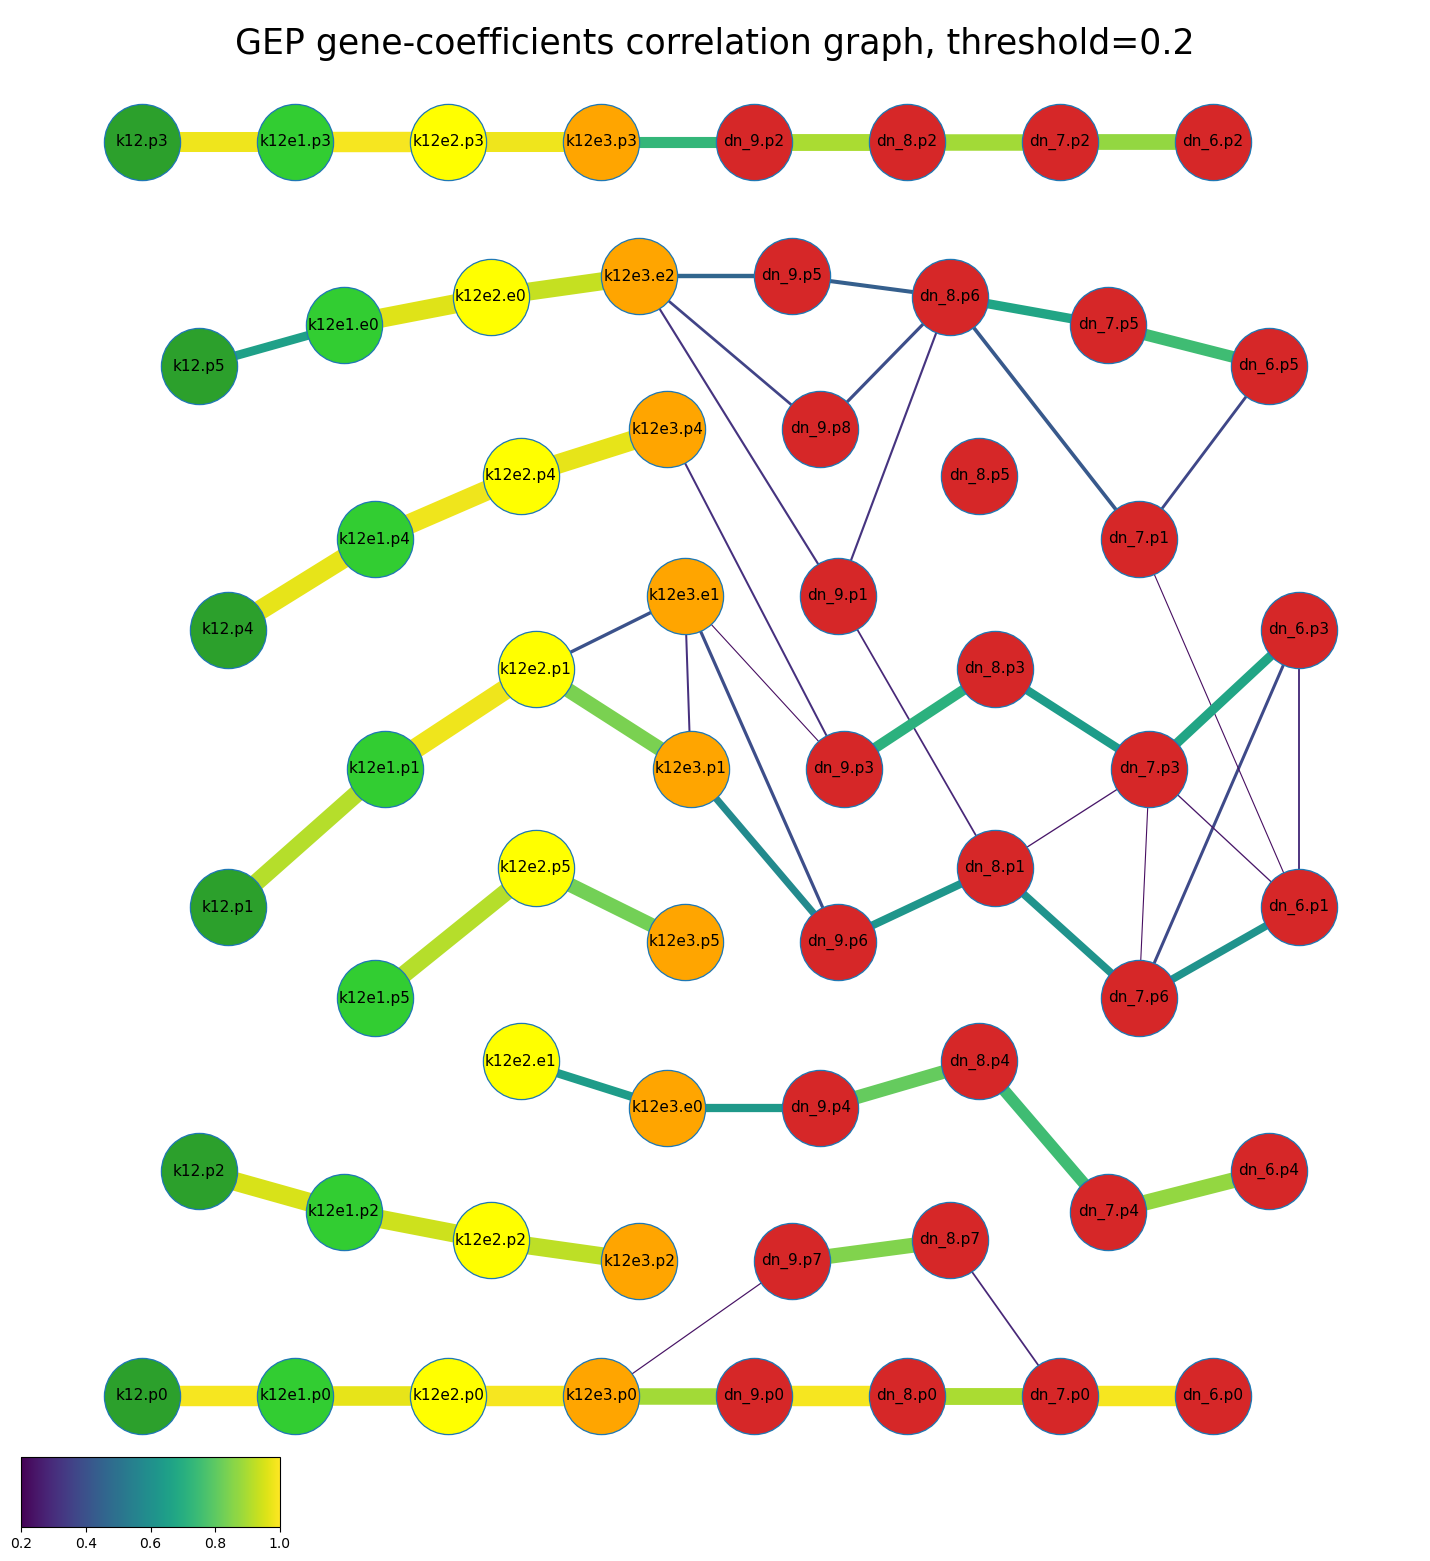

In [54]:
keys_lists = [['dn_6', 'dn_7', 'dn_8', 'dn_9', 'dn_10'],
              ['k12', 'k12e1', 'k12e2', 'k12e3', 'k12e4'],
              ['k12', 'k12e1', 'k12e2', 'k12e3', 'dn_9', 'dn_8', 'dn_7', 'dn_6'],
              ['k12', 'k12e1', 'k12e2', 'k12e3', 'dn_9', 'dn_8', 'dn_7', 'dn_6']]

threshold = 0.2

title = f'GEP gene-coefficients correlation graph, threshold={threshold}'

for keys in keys_lists:
    # aggregating data from the listed layers:
    ks, joint_prog_names, joint_usages, joint_labels, joint_colors = aggregate_ns_fields(decompositions, keys)

    prog_names_dict = {key: decompositions[key].prog_names for key in keys}


    # Creating the relevant adjacency matrix, here based on turncated Spearman correlation
    concatenated_spectras = pd.concat([
        decompositions[key].gene_coefs.copy() for key in keys], axis=1)

    n_genes, n_programs = concatenated_spectras.shape

    ranked_coefs = n_genes - rankdata(concatenated_spectras, axis=0)
    ranked_coefs[ranked_coefs > _constants.N_COMPARED_RANKED] = _constants.N_COMPARED_RANKED
    spearman_corr = np.corrcoef(ranked_coefs, rowvar=False)

    adj_df = get_ordered_adjacency_matrix(spearman_corr, joint_prog_names, ks, threshold)

    fig = plot_layered_correlation_graph(keys, adj_df, prog_names_dict, title)
    plt.show()

Number of edges=14


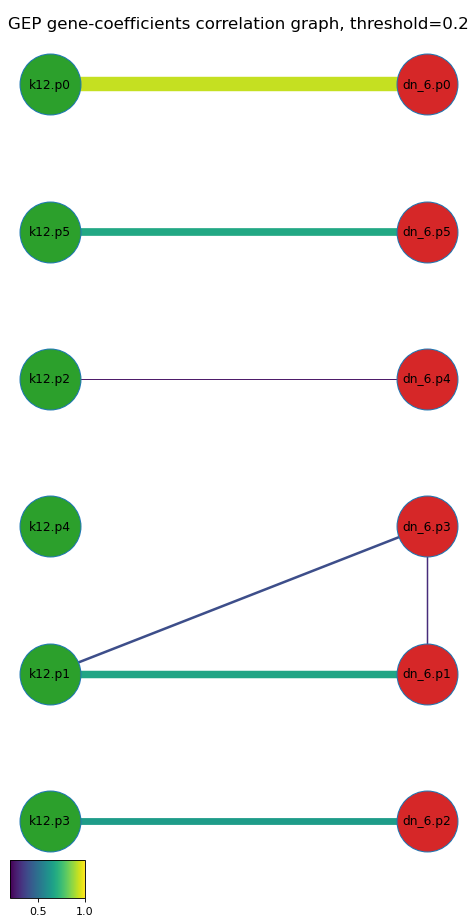

Number of edges=16


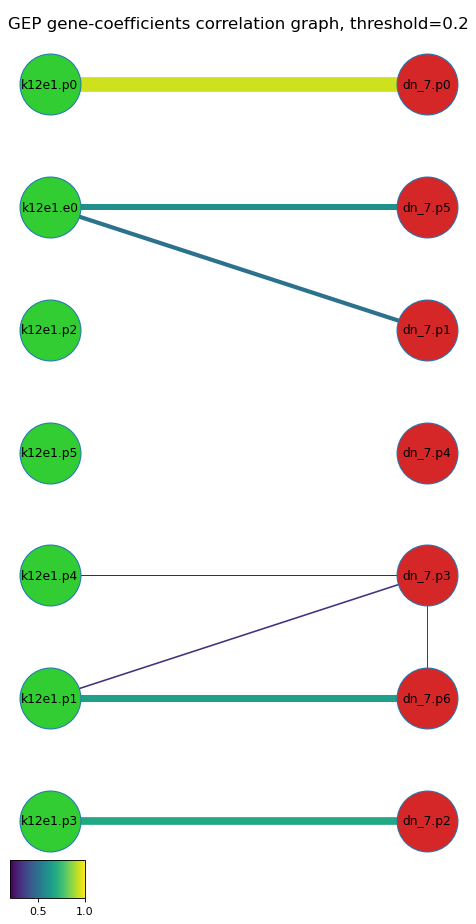

Number of edges=18


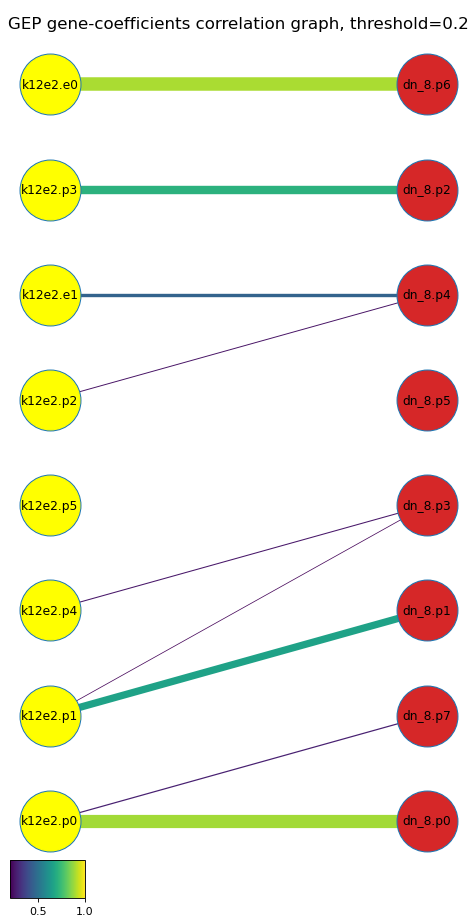

Number of edges=24


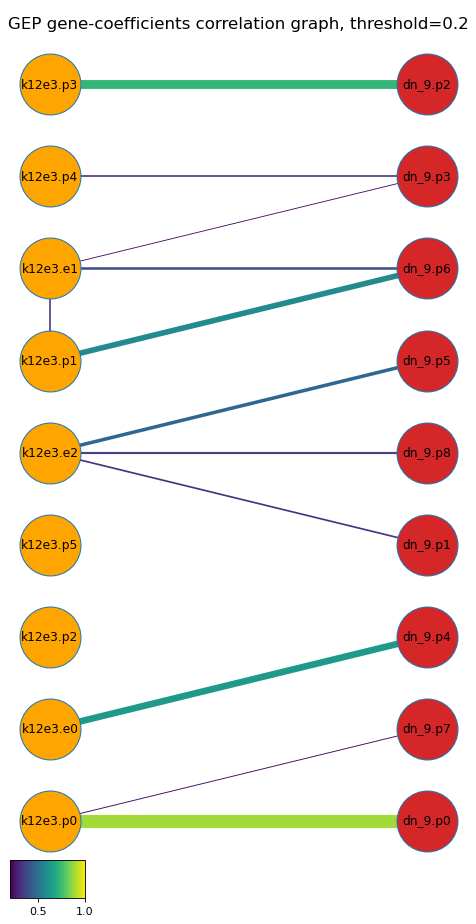

Number of edges=30


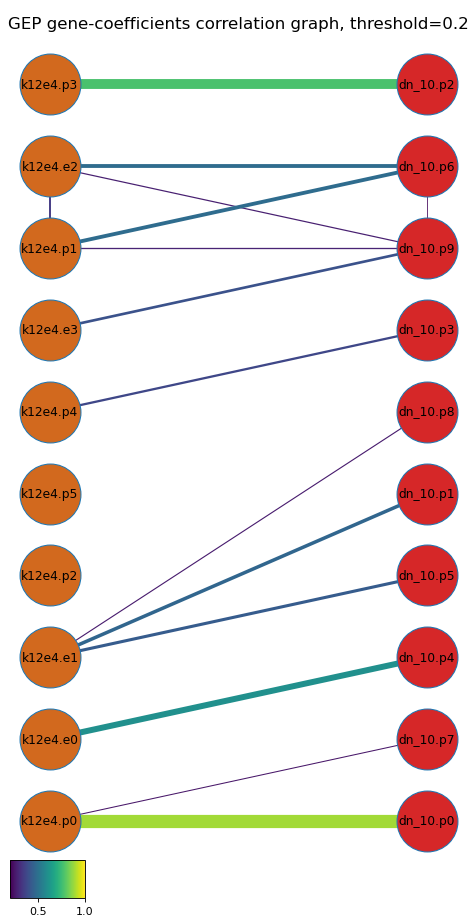

In [55]:
threshold = 0.2
title = f'GEP gene-coefficients correlation graph, threshold={threshold}'

for dn_name, pf_name in zip(['k12', 'k12e1', 'k12e2', 'k12e3', 'k12e4'],
                           ['dn_6', 'dn_7', 'dn_8', 'dn_9', 'dn_10']):
    keys = [dn_name, pf_name]
    # aggregating data from the listed layers:
    ks, joint_prog_names, joint_usages, joint_labels, joint_colors = aggregate_ns_fields(decompositions, keys)

    prog_names_dict = {key: decompositions[key].prog_names for key in keys}

    # Creating the relevant adjacency matrix, here based on turncated Spearman correlation
    concatenated_spectras = pd.concat([
        decompositions[key].gene_coefs.copy() for key in keys], axis=1)

    n_genes, n_programs = concatenated_spectras.shape

    ranked_coefs = n_genes - rankdata(concatenated_spectras, axis=0)
    ranked_coefs[ranked_coefs > _constants.N_COMPARED_RANKED] = _constants.N_COMPARED_RANKED
    spearman_corr = np.corrcoef(ranked_coefs, rowvar=False)

    adj_df = get_ordered_adjacency_matrix(spearman_corr, joint_prog_names, ks, threshold)

    fig = plot_layered_correlation_graph(keys, adj_df, prog_names_dict, title, {'figsize': (6, 12), 'dpi': 80}, {'fontsize': 15})
    plt.show(fig)
    plt.close(fig)
    


In [56]:
W = np.concatenate([ns.w1, ns.w2], axis=1)
W.shape

(2000, 10)

In [57]:
res = pfnmf.calc_beta_divergence(X30.T, ns.w1, np.zeros((2000, 0)), ns.h1, np.zeros((0, 505)), per_column=True)
res.shape

(505,)

In [58]:
np.zeros((2000, 0))

array([], shape=(2000, 0), dtype=float64)